In [59]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats
from scipy.stats import pearsonr
from scipy.optimize import curve_fit

import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec
from sklearn.metrics import mean_absolute_error as mae
from pathlib import Path

SECTION 1

1)THESE PARTS IN HPC (the next cell)--i.e preliminary big data organization performed using high computing power.
Data prepared from in HPC is loaded and used for the main analysis here
To streamline our analysis we used Data6 which is the summary of all the big data processing, 
hence should be able to run in any computer

In [60]:
plots_dir = Path("Plots")
plots_dir.mkdir(exist_ok=True)

In [61]:
required_data = Path("Required data")
required_data.exists()

True

In [62]:
data_output_dir = Path("Data outputs")
data_output_dir.exists()

True

In [63]:
Data6_path = data_output_dir / "Data6.csv"
Data6_path.exists()

True

In [64]:
AllCounts_path = required_data / "AllCounts.csv"
AllCounts_path.exists()

True

SECTION 2

In [65]:
# ------------------
# 2) ESTIMATE THE NUMBER OF FARM DAMS FROM 1990 TO 2030
# ------------------
# a) Load required files and data
Data6 = pd.read_csv(Data6_path)  # statistics on farm dam density from Weather-to-Water
AllCounts = pd.read_csv(
    AllCounts_path
)  # AllCounts: Number of farm dams from Remote Sensing article
Data6.head()

,NAME,FinYear,Date,SumArea_kha,SumArea_kha_LCI,SumArea_kha_UCI,EF,EF_LCI,EF_UCI,TotCH4_ktyear,TotCH4_ktyear_LCI,TotCH4_ktyear_UCI,Temp,Count
0,Australian Capital Territory,2016,2016-01-01,0.194233,0.106828,0.281638,0.285279,0.097750,0.862685,0.055644,0.010465,0.244488,20.698828,1220
1,Australian Capital Territory,2016,2016-02-01,0.201883,0.111035,0.292730,0.290050,0.098565,0.884395,0.058829,0.010970,0.260680,20.987658,1220
2,Australian Capital Territory,2016,2016-03-01,0.215355,0.118445,0.312265,0.269085,0.094936,0.790264,0.058149,0.011264,0.248037,19.688541,1220
3,Australian Capital Territory,2016,2016-04-01,0.197788,0.108784,0.286793,0.209720,0.083814,0.543707,0.041613,0.009132,0.156678,15.455789,1220
4,Australian Capital Territory,2016,2016-05-01,0.192468,0.105858,0.279079,0.155830,0.072248,0.348238,0.030058,0.007656,0.097503,10.567602,1220


In [66]:
AllCounts.head()

,Unnamed: 0,State,Count.50,Count.2.5,Count.97.5,Obs_count,AdjCoef,AdjCoef.LCI,AdjCoef.UCI
0,1,Australian Capital Territory,2143.63871,2035.527246,2247.168831,864,2.481063,2.355934,2.600890
1,2,New South Wales,654983.47000,648201.648700,663366.792800,191407,3.421941,3.386510,3.465739
2,3,Northern Territory,15183.13675,11824.106400,17723.562610,1,15183.136750,11824.106400,17723.562610
3,4,Queensland,234895.95490,211718.083400,315968.163800,148067,1.586417,1.429880,2.133954
4,5,South Australia,117001.78560,109899.675200,121687.801000,20334,5.753998,5.404725,5.984450


In [67]:
# Total farm dams in Australia in 2021
total_farm_dams = AllCounts["Count.50"].sum()
print("Total farm dams in 2021:", total_farm_dams)

# Process AllCounts data
AllCounts2 = AllCounts[["State", "Count.50", "Count.2.5", "Count.97.5"]].rename(
    columns={
        "State": "NAME",
        "Count.50": "ObsCount.2021",
        "Count.2.5": "ObsCount.2021.LCI",
        "Count.97.5": "ObsCount.2021.UCI",
    }
)
print(AllCounts2)
# Save AllCounts2 data if necessary
# AllCounts2.to_csv("Required data/full preds v7/AllCounts2.csv", index=False)

# Display sums for checking
print("Sum ObsCount.2021:", AllCounts2["ObsCount.2021"].sum())
print("Sum ObsCount.2021.LCI:", AllCounts2["ObsCount.2021.LCI"].sum())
print("Sum ObsCount.2021.UCI:", AllCounts2["ObsCount.2021.UCI"].sum())

# Load the statistics on farm dam density from Weather-to-Water
# Group by NAME and summarize to compute adjustment coefficients
AllCounts3 = (
    Data6.groupby("NAME")
    .agg({"Count": "first"})
    .rename(columns={"Count": "FD.count"})
    .reset_index()
    .merge(AllCounts2, on="NAME", how="outer")
    .dropna(subset=["FD.count"])
    .query("NAME not in ['Northern Territory', 'Other Territories']")
    .assign(
        # These are the adjustment coefficients to upscale Nick's data to cover all farm dams
        **{
            "AdjCoef": lambda x: x["ObsCount.2021"] / x["FD.count"],
            "AdjCoef.LCI": lambda x: x["ObsCount.2021.LCI"] / x["FD.count"],
            "AdjCoef.UCI": lambda x: x["ObsCount.2021.UCI"] / x["FD.count"],
        }
    )
)

Total farm dams in 2021: 1765152.035
                           NAME  ObsCount.2021  ObsCount.2021.LCI  \
0  Australian Capital Territory     2143.63871        2035.527246   
1               New South Wales   654983.47000      648201.648700   
2            Northern Territory    15183.13675       11824.106400   
3                    Queensland   234895.95490      211718.083400   
4               South Australia   117001.78560      109899.675200   
5                      Tasmania    63418.24104       55877.758550   
6                      Victoria   439964.60830      409958.563800   
7             Western Australia   237561.19970      218803.560200   

   ObsCount.2021.UCI  
0        2247.168831  
1      663366.792800  
2       17723.562610  
3      315968.163800  
4      121687.801000  
5       70987.293130  
6      458836.974600  
7      256622.267000  
Sum ObsCount.2021: 1765152.035
Sum ObsCount.2021.LCI: 1668318.923496
Sum ObsCount.2021.UCI: 1907440.023771


In [68]:
AllCounts3

,NAME,FD.count,ObsCount.2021,ObsCount.2021.LCI,ObsCount.2021.UCI,AdjCoef,AdjCoef.LCI,AdjCoef.UCI
0,Australian Capital Territory,1220.0,2143.63871,2035.527246,2247.168831,1.757081,1.668465,1.841942
1,New South Wales,388262.0,654983.47000,648201.648700,663366.792800,1.686963,1.669495,1.708555
4,Queensland,204475.0,234895.95490,211718.083400,315968.163800,1.148776,1.035423,1.545266
5,South Australia,82091.0,117001.78560,109899.675200,121687.801000,1.425269,1.338754,1.482353
6,Tasmania,52314.0,63418.24104,55877.758550,70987.293130,1.212261,1.068122,1.356946
7,Victoria,332130.0,439964.60830,409958.563800,458836.974600,1.324676,1.234332,1.381498
8,Western Australia,160332.0,237561.19970,218803.560200,256622.267000,1.481683,1.364691,1.600568


In [69]:
AllCounts3.to_csv(data_output_dir / "AllCounts3.csv", index=False)

In [70]:
# Adjust counts in W-to-W to include AdjCoef (excluding NT for which we have only 1 dam)
# Select wanted specific columns
Data7 = AllCounts3[["NAME", "AdjCoef", "AdjCoef.LCI", "AdjCoef.UCI", "ObsCount.2021"]]

# Merge with Data6
Data7 = pd.merge(Data7, Data6, on="NAME", how="outer")

# Filter out rows where 'NAME' is 'Northern Territory' or 'Other Territories'
Data7 = Data7[~Data7["NAME"].isin(["Northern Territory", "Other Territories"])]

# Drop rows with NA values
Data7.dropna(inplace=True)

# Display the first few rows of the DataFrame to verify
Data7.head()

,NAME,AdjCoef,AdjCoef.LCI,AdjCoef.UCI,ObsCount.2021,FinYear,Date,SumArea_kha,SumArea_kha_LCI,SumArea_kha_UCI,EF,EF_LCI,EF_UCI,TotCH4_ktyear,TotCH4_ktyear_LCI,TotCH4_ktyear_UCI,Temp,Count
0,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-01-01,0.194233,0.106828,0.281638,0.285279,0.097750,0.862685,0.055644,0.010465,0.244488,20.698828,1220
1,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-02-01,0.201883,0.111035,0.292730,0.290050,0.098565,0.884395,0.058829,0.010970,0.260680,20.987658,1220
2,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-03-01,0.215355,0.118445,0.312265,0.269085,0.094936,0.790264,0.058149,0.011264,0.248037,19.688541,1220
3,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-04-01,0.197788,0.108784,0.286793,0.209720,0.083814,0.543707,0.041613,0.009132,0.156678,15.455789,1220
4,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-05-01,0.192468,0.105858,0.279079,0.155830,0.072248,0.348238,0.030058,0.007656,0.097503,10.567602,1220


In [71]:
# Create adjusted coefficient columns
Data7["Count.AdjCoef"] = Data7["Count"] * Data7["AdjCoef"]
Data7["Count.AdjCoef.LCI"] = Data7["Count"] * Data7["AdjCoef.LCI"]
Data7["Count.AdjCoef.UCI"] = Data7["Count"] * Data7["AdjCoef.UCI"]

Data7["SumArea.kha.AdjCoef"] = Data7["SumArea_kha"] * Data7["AdjCoef"]
Data7["SumArea.kha_LCI.AdjCoef"] = Data7["SumArea_kha_LCI"] * Data7["AdjCoef.LCI"]
Data7["SumArea.kha_UCI.AdjCoef"] = Data7["SumArea_kha_UCI"] * Data7["AdjCoef.UCI"]

Data7["TotCH4.ktyear.AdjCoef"] = Data7["TotCH4_ktyear"] * Data7["AdjCoef"]
Data7["TotCH4.ktyear_LCI.AdjCoef"] = Data7["TotCH4_ktyear_LCI"] * Data7["AdjCoef.LCI"]
Data7["TotCH4.ktyear_UCI.AdjCoef"] = Data7["TotCH4_ktyear_UCI"] * Data7["AdjCoef.UCI"]
Data7.head()

,NAME,AdjCoef,AdjCoef.LCI,AdjCoef.UCI,ObsCount.2021,FinYear,Date,SumArea_kha,SumArea_kha_LCI,SumArea_kha_UCI,...,Count,Count.AdjCoef,Count.AdjCoef.LCI,Count.AdjCoef.UCI,SumArea.kha.AdjCoef,SumArea.kha_LCI.AdjCoef,SumArea.kha_UCI.AdjCoef,TotCH4.ktyear.AdjCoef,TotCH4.ktyear_LCI.AdjCoef,TotCH4.ktyear_UCI.AdjCoef
0,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-01-01,0.194233,0.106828,0.281638,...,1220,2143.63871,2035.527246,2247.168831,0.341284,0.178239,0.518761,0.097772,0.017460,0.450332
1,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-02-01,0.201883,0.111035,0.292730,...,1220,2143.63871,2035.527246,2247.168831,0.354724,0.185259,0.539191,0.103368,0.018303,0.480158
2,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-03-01,0.215355,0.118445,0.312265,...,1220,2143.63871,2035.527246,2247.168831,0.378397,0.197622,0.575174,0.102173,0.018794,0.456869
3,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-04-01,0.197788,0.108784,0.286793,...,1220,2143.63871,2035.527246,2247.168831,0.347530,0.181502,0.528256,0.073118,0.015237,0.288592
4,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-05-01,0.192468,0.105858,0.279079,...,1220,2143.63871,2035.527246,2247.168831,0.338182,0.176620,0.514047,0.052815,0.012774,0.179595


In [72]:
# Save
Data7.to_csv(required_data / "Data7.csv", index=False)

In [73]:
# Check ballpark values
# For Data7 in the year 2021
data7_2021 = Data7[Data7["FinYear"] == 2021]
grouped_2021 = data7_2021.groupby("NAME").agg(
    TotCH4_ktyear_AdjCoef=("TotCH4.ktyear.AdjCoef", "mean")
)
total_ch4_2021 = grouped_2021["TotCH4_ktyear_AdjCoef"].sum()
print("Total CH4 Adjusted Coefficient for 2021:", total_ch4_2021)

# For Data6 in the year 2021
data6_2021 = Data6[Data6["FinYear"] == 2021]
grouped_data6_2021 = data6_2021.groupby("NAME").agg(
    TotCH4_ktyear=("TotCH4_ktyear", "mean")
)
total_ch4_data6_2021 = grouped_data6_2021["TotCH4_ktyear"].sum()
print("Total CH4 for 2021:", total_ch4_data6_2021)

# For Data7 in the year 2022
data7_2022 = Data7[Data7["FinYear"] == 2022]
grouped_2022 = data7_2022.groupby("NAME").agg(
    TotCH4_ktyear_AdjCoef=("TotCH4.ktyear.AdjCoef", "mean")
)
total_ch4_2022 = grouped_2022["TotCH4_ktyear_AdjCoef"].sum()
print("Total CH4 Adjusted Coefficient for 2022:", total_ch4_2022)

# Test with a plot
# Plotting for Australian Capital Territory
test_plot = Data7[
    (Data7["NAME"] == "Australian Capital Territory")
    & (Data7["FinYear"].isin([2021, 2022]))
].copy()
test_plot["Date"] = pd.to_datetime(
    test_plot["Date"]
)  # Ensure 'Date' is in datetime format

Total CH4 Adjusted Coefficient for 2021: 36.741733431414865
Total CH4 for 2021: 26.43456382454932
Total CH4 Adjusted Coefficient for 2022: 41.68663518009465


In [74]:
Data7

,NAME,AdjCoef,AdjCoef.LCI,AdjCoef.UCI,ObsCount.2021,FinYear,Date,SumArea_kha,SumArea_kha_LCI,SumArea_kha_UCI,...,Count,Count.AdjCoef,Count.AdjCoef.LCI,Count.AdjCoef.UCI,SumArea.kha.AdjCoef,SumArea.kha_LCI.AdjCoef,SumArea.kha_UCI.AdjCoef,TotCH4.ktyear.AdjCoef,TotCH4.ktyear_LCI.AdjCoef,TotCH4.ktyear_UCI.AdjCoef
0,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-01-01,0.194233,0.106828,0.281638,...,1220,2143.63871,2035.527246,2247.168831,0.341284,0.178239,0.518761,0.097772,0.017460,0.450332
1,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-02-01,0.201883,0.111035,0.292730,...,1220,2143.63871,2035.527246,2247.168831,0.354724,0.185259,0.539191,0.103368,0.018303,0.480158
2,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-03-01,0.215355,0.118445,0.312265,...,1220,2143.63871,2035.527246,2247.168831,0.378397,0.197622,0.575174,0.102173,0.018794,0.456869
3,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-04-01,0.197788,0.108784,0.286793,...,1220,2143.63871,2035.527246,2247.168831,0.347530,0.181502,0.528256,0.073118,0.015237,0.288592
4,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-05-01,0.192468,0.105858,0.279079,...,1220,2143.63871,2035.527246,2247.168831,0.338182,0.176620,0.514047,0.052815,0.012774,0.179595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,Western Australia,1.481683,1.364691,1.600568,237561.19970,2024,2023-08-01,12.070480,6.638764,17.502196,...,160332,237561.19970,218803.560200,256622.267000,17.884625,9.059858,28.013455,3.101010,0.690203,11.462401
764,Western Australia,1.481683,1.364691,1.600568,237561.19970,2024,2023-09-01,11.835056,6.509281,17.160831,...,160332,237561.19970,218803.560200,256622.267000,17.535801,8.883154,27.467077,3.617246,0.738032,14.589890
765,Western Australia,1.481683,1.364691,1.600568,237561.19970,2024,2023-10-01,8.936358,4.914997,12.957719,...,160332,237561.19970,218803.560200,256622.267000,13.240849,6.707449,20.739709,3.055908,0.589213,13.054926
766,Western Australia,1.481683,1.364691,1.600568,237561.19970,2024,2023-11-01,9.231265,5.077196,13.385334,...,160332,237561.19970,218803.560200,256622.267000,13.677808,6.928801,21.424137,3.787654,0.666352,17.753591


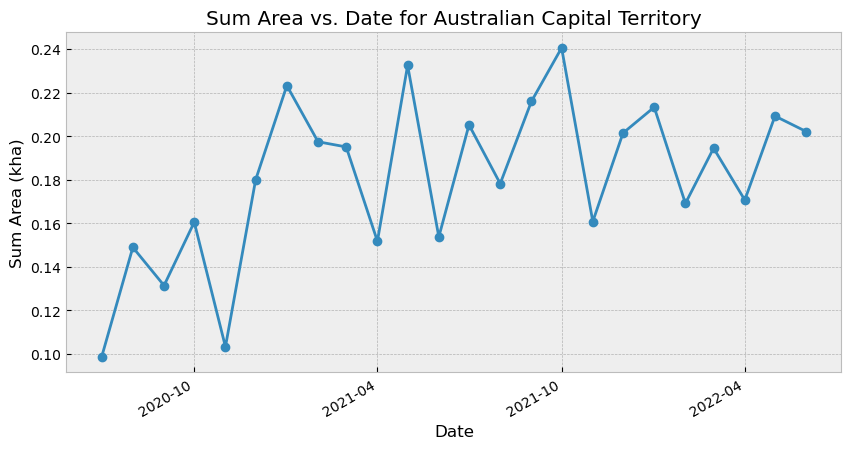

In [75]:
plt.figure(figsize=(10, 5))
plt.plot(test_plot["Date"], test_plot["SumArea_kha"], marker="o", linestyle="-")
plt.title("Sum Area vs. Date for Australian Capital Territory")
plt.xlabel("Date")
plt.ylabel("Sum Area (kha)")
plt.grid(True)
# Define the date format and interval
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate()
plt.show()

In [76]:
# Calculate NT Count and Percent Count 0.0086 or 0.86%
NT_Count = AllCounts.loc[AllCounts["State"] == "Northern Territory", "Count.50"].sum()
Total_Count = AllCounts["Count.50"].sum()
NT_PercCount = NT_Count / Total_Count

# Calculate adjusted coefficients for Northern Territory
grouped = Data7.groupby(["Date", "FinYear"])
aggregated = grouped.agg(
    {
        "SumArea.kha.AdjCoef": lambda x: sum(x) * NT_PercCount,
        "SumArea.kha_LCI.AdjCoef": lambda x: sum(x) * NT_PercCount,
        "SumArea.kha_UCI.AdjCoef": lambda x: sum(x) * NT_PercCount,
        "TotCH4.ktyear.AdjCoef": lambda x: sum(x) * NT_PercCount,
        "TotCH4.ktyear_LCI.AdjCoef": lambda x: sum(x) * NT_PercCount,
        "TotCH4.ktyear_UCI.AdjCoef": lambda x: sum(x) * NT_PercCount,
        "Count.AdjCoef": lambda x: sum(x) * NT_PercCount,
        "Count.AdjCoef.LCI": lambda x: sum(x) * NT_PercCount,
        "Count.AdjCoef.UCI": lambda x: sum(x) * NT_PercCount,
    }
)

aggregated

,,SumArea.kha.AdjCoef,SumArea.kha_LCI.AdjCoef,SumArea.kha_UCI.AdjCoef,TotCH4.ktyear.AdjCoef,TotCH4.ktyear_LCI.AdjCoef,TotCH4.ktyear_UCI.AdjCoef,Count.AdjCoef,Count.AdjCoef.LCI,Count.AdjCoef.UCI
Date,FinYear,,,,,,,,,
2016-01-01,2016,1.373900,0.714564,2.210218,0.466103,0.075829,2.548667,15052.537438,14248.510516,16254.590471
2016-02-01,2016,1.408125,0.731375,2.274141,0.480564,0.077842,2.649112,15052.537438,14248.510516,16254.590471
2016-03-01,2016,1.353181,0.702078,2.192789,0.432561,0.072320,2.317237,15052.537438,14248.510516,16254.590471
2016-04-01,2016,1.310448,0.679149,2.126013,0.345956,0.063478,1.704531,15052.537438,14248.510516,16254.590471
2016-05-01,2016,1.295560,0.671471,2.095322,0.268672,0.055528,1.180935,15052.537438,14248.510516,16254.590471
...,...,...,...,...,...,...,...,...,...,...
2023-08-01,2024,1.509944,0.785173,2.403187,0.265647,0.059907,1.047802,15052.537438,14248.510516,16254.590471
2023-09-01,2024,1.277325,0.662238,2.031847,0.265900,0.054999,1.136535,15052.537438,14248.510516,16254.590471
2023-10-01,2024,1.138015,0.591114,1.803308,0.259889,0.051316,1.171242,15052.537438,14248.510516,16254.590471


In [77]:
# Adding fixed values and additional columns
aggregated["NAME"] = "Northern Territory"
aggregated.reset_index(inplace=True)
additional_cols = [
    "AdjCoef",
    "ObsCount.2021",
    "SumArea.kha",
    "SumArea.kha_LCI",
    "SumArea.kha_UCI",
    "TotCH4.ktyear",
    "TotCH4.ktyear_LCI",
    "TotCH4.ktyear_UCI",
    "EF",
    "EF_LCI",
    "EF_UCI",
    "Temp",
    "Count",
    "AdjCoef.LCI",
    "AdjCoef.UCI",
]
for col in additional_cols:
    aggregated[col] = np.nan
aggregated["ObsCount.2021"] = NT_Count

# Concatenate with original Data7 DataFrame
Data7_NT = pd.concat([Data7, aggregated])

# save the updated DataFrame
Data7_NT.to_csv(data_output_dir / "Data7_NT.csv", index=False)
Data7_NT.head()

,NAME,AdjCoef,AdjCoef.LCI,AdjCoef.UCI,ObsCount.2021,FinYear,Date,SumArea_kha,SumArea_kha_LCI,SumArea_kha_UCI,...,SumArea.kha_UCI.AdjCoef,TotCH4.ktyear.AdjCoef,TotCH4.ktyear_LCI.AdjCoef,TotCH4.ktyear_UCI.AdjCoef,SumArea.kha,SumArea.kha_LCI,SumArea.kha_UCI,TotCH4.ktyear,TotCH4.ktyear_LCI,TotCH4.ktyear_UCI
0,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-01-01,0.194233,0.106828,0.281638,...,0.518761,0.097772,0.017460,0.450332,NaN,NaN,NaN,NaN,NaN,NaN
1,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-02-01,0.201883,0.111035,0.292730,...,0.539191,0.103368,0.018303,0.480158,NaN,NaN,NaN,NaN,NaN,NaN
2,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-03-01,0.215355,0.118445,0.312265,...,0.575174,0.102173,0.018794,0.456869,NaN,NaN,NaN,NaN,NaN,NaN
3,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-04-01,0.197788,0.108784,0.286793,...,0.528256,0.073118,0.015237,0.288592,NaN,NaN,NaN,NaN,NaN,NaN
4,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-05-01,0.192468,0.105858,0.279079,...,0.514047,0.052815,0.012774,0.179595,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
# Load historical increase in farm dams from Remote Sensing article
# Python: Load the CSV file/ Data6.kha.hist.csv is replaced with MyECDF.single3
HistData = pd.read_csv(required_data / "MyECDF.single3.csv")
# Filter the DataFrame
HistData = HistData[HistData["FinYear"].between(1990, 2021)]
# Select only the necessary columns
HistData = HistData[["State", "FinYear", "ecd"]]
# Note: Historical increase for the NT calculated using ecd for Australia

# Create a dataframe for the years 1990 to 2030 and merge with historical data
states = HistData["State"].unique()
fin_years = np.arange(1990, 2031)
HistData_exp = pd.DataFrame(
    [(state, year) for state in states for year in fin_years],
    columns=["State", "FinYear"],
)
# Merge the new DataFrame with the original one
HistData_exp = pd.merge(HistData_exp, HistData, on=["State", "FinYear"], how="outer")

# Calculate future historical trends based on observations from 2005 and 2015
# Fit a linear model using a subset of the HisData_exp from 2006
HistData_exp_subset = HistData_exp[HistData_exp["FinYear"] > 2005]
HistData_lm = smf.ols(formula="ecd ~ FinYear*State", data=HistData_exp_subset).fit()
# Make predictions
HistData_exp["ecd.pred"] = HistData_lm.predict(HistData_exp)
# Select specific columns
HistData_exp = HistData_exp[["State", "FinYear", "ecd", "ecd.pred"]]
# check the first few columns which should now have the ecd_pred values
HistData_exp.head()

,State,FinYear,ecd,ecd.pred
0,Australian Capital Territory,1990,0.508197,0.630204
1,Australian Capital Territory,1991,0.516393,0.645604
2,Australian Capital Territory,1992,0.524590,0.661003
3,Australian Capital Territory,1993,0.590164,0.676403
4,Australian Capital Territory,1994,0.639344,0.691803


In [79]:
# If we have observations, keep that. Otherwise use ecd_pred
HistData_exp["ecd.comb"] = HistData_exp["ecd"].where(
    HistData_exp["ecd"].notna(), HistData_exp["ecd.pred"]
)

# Set the value for 2021 as 1 in each State
HistData_adj = HistData_exp.copy()
# Group by State and calculate ecd.adj

base_values = HistData_adj[HistData_adj["FinYear"] == 2021].set_index("State")[
    "ecd.comb"
]

HistData_adj["ecd.adj"] = HistData_adj.groupby("State")["ecd.comb"].transform(
    lambda x: x / base_values[x.name]
)
# Convert FinYear to categorical
HistData_adj["FinYear"] = HistData_adj["FinYear"].astype("category")
# Rename State to NAME
HistData_adj = HistData_adj.rename(columns={"State": "NAME"})
# Select specific columns
HistData_adj = HistData_adj[["NAME", "FinYear", "ecd.adj"]]

# Check. Works!
HistData_adj["FinYear"][HistData_adj["ecd.adj"] == 1]

31     2021
72     2021
113    2021
154    2021
195    2021
236    2021
277    2021
318    2021
Name: FinYear, dtype: category
Categories (41, int64): [1990, 1991, 1992, 1993, ..., 2027, 2028, 2029, 2030]

In [80]:
# Merge with rest of data
Data8 = pd.merge(Data7_NT, HistData_adj, on=["NAME", "FinYear"])
Data8

,NAME,AdjCoef,AdjCoef.LCI,AdjCoef.UCI,ObsCount.2021,FinYear,Date,SumArea_kha,SumArea_kha_LCI,SumArea_kha_UCI,...,TotCH4.ktyear.AdjCoef,TotCH4.ktyear_LCI.AdjCoef,TotCH4.ktyear_UCI.AdjCoef,SumArea.kha,SumArea.kha_LCI,SumArea.kha_UCI,TotCH4.ktyear,TotCH4.ktyear_LCI,TotCH4.ktyear_UCI,ecd.adj
0,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-01-01,0.194233,0.106828,0.281638,...,0.097772,0.017460,0.450332,NaN,NaN,NaN,NaN,NaN,NaN,0.930481
1,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-02-01,0.201883,0.111035,0.292730,...,0.103368,0.018303,0.480158,NaN,NaN,NaN,NaN,NaN,NaN,0.930481
2,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-03-01,0.215355,0.118445,0.312265,...,0.102173,0.018794,0.456869,NaN,NaN,NaN,NaN,NaN,NaN,0.930481
3,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-04-01,0.197788,0.108784,0.286793,...,0.073118,0.015237,0.288592,NaN,NaN,NaN,NaN,NaN,NaN,0.930481
4,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2016,2016-05-01,0.192468,0.105858,0.279079,...,0.052815,0.012774,0.179595,NaN,NaN,NaN,NaN,NaN,NaN,0.930481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,Northern Territory,NaN,NaN,NaN,15183.13675,2024,2023-08-01,NaN,NaN,NaN,...,0.265647,0.059907,1.047802,NaN,NaN,NaN,NaN,NaN,NaN,1.014313
764,Northern Territory,NaN,NaN,NaN,15183.13675,2024,2023-09-01,NaN,NaN,NaN,...,0.265900,0.054999,1.136535,NaN,NaN,NaN,NaN,NaN,NaN,1.014313
765,Northern Territory,NaN,NaN,NaN,15183.13675,2024,2023-10-01,NaN,NaN,NaN,...,0.259889,0.051316,1.171242,NaN,NaN,NaN,NaN,NaN,NaN,1.014313
766,Northern Territory,NaN,NaN,NaN,15183.13675,2024,2023-11-01,NaN,NaN,NaN,...,0.330513,0.059674,1.611126,NaN,NaN,NaN,NaN,NaN,NaN,1.014313


In [81]:
# Create new columns
Data8["SumArea.kha.AdjCoef.ecd"] = Data8["SumArea.kha.AdjCoef"] * Data8["ecd.adj"]
Data8["SumArea.kha_LCI.AdjCoef.ecd"] = (
    Data8["SumArea.kha_LCI.AdjCoef"] * Data8["ecd.adj"]
)
Data8["SumArea.kha_UCI.AdjCoef.ecd"] = (
    Data8["SumArea.kha_UCI.AdjCoef"] * Data8["ecd.adj"]
)

Data8["TotCH4.ktyear.AdjCoef.ecd"] = Data8["TotCH4.ktyear.AdjCoef"] * Data8["ecd.adj"]
Data8["TotCH4.ktyear_LCI.AdjCoef.ecd"] = (
    Data8["TotCH4.ktyear_LCI.AdjCoef"] * Data8["ecd.adj"]
)
Data8["TotCH4.ktyear_UCI.AdjCoef.ecd"] = (
    Data8["TotCH4.ktyear_UCI.AdjCoef"] * Data8["ecd.adj"]
)

Data8["Count.AdjCoef.ecd"] = Data8["Count.AdjCoef"] * Data8["ecd.adj"]
Data8["Count.AdjCoef.LCI.ecd"] = Data8["Count.AdjCoef.LCI"] * Data8["ecd.adj"]
Data8["Count.AdjCoef.UCI.ecd"] = Data8["Count.AdjCoef.UCI"] * Data8["ecd.adj"]

# save
Data8.to_csv(data_output_dir / "Data8.csv", index=False)
# Check stats
Data8.loc[Data8["FinYear"] == 2021, "Count.AdjCoef"].unique().sum()

Data8["N.months"] = Data8.groupby(["FinYear", "NAME"])["Date"].transform("count")

# remove rows with N.months < 12
Data8 = Data8[Data8["N.months"] == 12]
# Data8.head()

In [82]:
Data8

,NAME,AdjCoef,AdjCoef.LCI,AdjCoef.UCI,ObsCount.2021,FinYear,Date,SumArea_kha,SumArea_kha_LCI,SumArea_kha_UCI,...,SumArea.kha.AdjCoef.ecd,SumArea.kha_LCI.AdjCoef.ecd,SumArea.kha_UCI.AdjCoef.ecd,TotCH4.ktyear.AdjCoef.ecd,TotCH4.ktyear_LCI.AdjCoef.ecd,TotCH4.ktyear_UCI.AdjCoef.ecd,Count.AdjCoef.ecd,Count.AdjCoef.LCI.ecd,Count.AdjCoef.UCI.ecd,N.months
6,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2017,2016-07-01,0.180510,0.099281,0.261740,...,0.299532,0.156434,0.455297,0.037890,0.010183,0.115952,2024.419478,1922.320671,2122.191734,12
7,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2017,2016-08-01,0.223515,0.122933,0.324096,...,0.370891,0.193702,0.563766,0.047487,0.012685,0.146206,2024.419478,1922.320671,2122.191734,12
8,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2017,2016-09-01,0.202984,0.111641,0.294327,...,0.336824,0.175910,0.511982,0.050793,0.012503,0.169718,2024.419478,1922.320671,2122.191734,12
9,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2017,2016-10-01,0.240053,0.132029,0.348077,...,0.398335,0.208035,0.605481,0.066332,0.015537,0.232929,2024.419478,1922.320671,2122.191734,12
10,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,2017,2016-11-01,0.223614,0.122988,0.324240,...,0.371056,0.193788,0.564016,0.082212,0.016695,0.332977,2024.419478,1922.320671,2122.191734,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,Northern Territory,NaN,NaN,NaN,15183.13675,2023,2023-02-01,NaN,NaN,NaN,...,1.541150,0.802088,2.467077,0.500859,0.083329,2.666701,15196.168031,14384.469123,16409.690998,12
758,Northern Territory,NaN,NaN,NaN,15183.13675,2023,2023-03-01,NaN,NaN,NaN,...,1.462489,0.760925,2.343204,0.443173,0.076211,2.303966,15196.168031,14384.469123,16409.690998,12
759,Northern Territory,NaN,NaN,NaN,15183.13675,2023,2023-04-01,NaN,NaN,NaN,...,1.461036,0.759021,2.350744,0.336940,0.066270,1.543222,15196.168031,14384.469123,16409.690998,12
760,Northern Territory,NaN,NaN,NaN,15183.13675,2023,2023-05-01,NaN,NaN,NaN,...,1.304576,0.678321,2.075780,0.224005,0.051166,0.864970,15196.168031,14384.469123,16409.690998,12


In [83]:
# Summarise by State-by-Year and by Year
# Group by 'FinYear' and 'NAME', and calculate the statistics
Data9 = (
    Data8.groupby(["FinYear", "NAME"])
    .agg(
        {
            "Count.AdjCoef.ecd": "first",
            "Count.AdjCoef.LCI.ecd": "first",
            "Count.AdjCoef.UCI.ecd": "first",
            "SumArea.kha.AdjCoef": "mean",
            "SumArea.kha_LCI.AdjCoef": "mean",
            "SumArea.kha_UCI.AdjCoef": "mean",
            "SumArea.kha.AdjCoef.ecd": "mean",
            "SumArea.kha_LCI.AdjCoef.ecd": "mean",
            "SumArea.kha_UCI.AdjCoef.ecd": "mean",
            "TotCH4.ktyear.AdjCoef.ecd": "mean",
            "TotCH4.ktyear_LCI.AdjCoef.ecd": "mean",
            "TotCH4.ktyear_UCI.AdjCoef.ecd": "mean",
            "EF": "mean",
            "EF_LCI": "mean",
            "EF_UCI": "mean",
        }
    )
    .reset_index()
)

In [84]:
Data9

,FinYear,NAME,Count.AdjCoef.ecd,Count.AdjCoef.LCI.ecd,Count.AdjCoef.UCI.ecd,SumArea.kha.AdjCoef,SumArea.kha_LCI.AdjCoef,SumArea.kha_UCI.AdjCoef,SumArea.kha.AdjCoef.ecd,SumArea.kha_LCI.AdjCoef.ecd,SumArea.kha_UCI.AdjCoef.ecd,TotCH4.ktyear.AdjCoef.ecd,TotCH4.ktyear_LCI.AdjCoef.ecd,TotCH4.ktyear_UCI.AdjCoef.ecd,EF,EF_LCI,EF_UCI
0,2017,Australian Capital Territory,2024.419478,1922.320671,2122.191734,0.345088,0.180226,0.524545,0.325896,0.170203,0.495372,0.066871,0.013907,0.272023,0.198836,0.080358,0.525331
1,2017,New South Wales,652035.411663,645284.115110,660381.001412,66.312679,36.094336,97.384079,66.014208,35.931876,96.945757,15.983056,3.180698,68.809066,0.239843,0.088045,0.701003
2,2017,Northern Territory,14765.276251,13976.593302,15944.389419,1.490983,0.774983,2.378763,1.462529,0.760194,2.333366,0.353727,0.067305,1.685929,NaN,NaN,NaN
3,2017,Queensland,226338.725213,204005.220616,304457.483879,35.701178,17.698141,69.633519,34.400589,17.053400,67.096779,10.703541,1.721812,68.094536,0.310692,0.100887,1.012859
4,2017,South Australia,115145.351318,108155.928097,119757.015035,7.203231,3.721294,10.863003,7.088939,3.662249,10.690643,1.530462,0.308468,6.248529,0.214844,0.084001,0.580669
5,2017,Tasmania,61904.121643,54543.669229,69292.461553,6.006542,2.910797,9.748974,5.863135,2.841302,9.516216,1.030723,0.216942,4.030148,0.173794,0.075893,0.416698
6,2017,Victoria,435153.189610,405475.288876,453819.169182,38.627956,19.796419,58.413119,38.205523,19.579927,57.774317,7.812040,1.604905,31.127815,0.204306,0.081905,0.538665
7,2017,Western Australia,232734.056421,214357.564236,251407.810881,19.141094,9.696351,29.981516,18.752155,9.499325,29.372305,4.094719,0.805172,17.426295,0.224701,0.085947,0.619968
8,2018,Australian Capital Territory,2054.224286,1950.622315,2153.436008,0.221432,0.115645,0.336583,0.212195,0.110821,0.322543,0.044076,0.009108,0.180172,0.201216,0.080936,0.532038
9,2018,New South Wales,652772.426247,646013.498507,661127.449259,42.181155,22.959422,61.945514,42.038763,22.881917,61.736403,10.359244,2.044596,44.832186,0.244323,0.088980,0.716795


In [85]:
# Year
# Further group by 'FinYear' and calculate the statistics
Data10 = (
    Data9.groupby("FinYear")
    .agg(
        {
            "Count.AdjCoef.ecd": "sum",
            "Count.AdjCoef.LCI.ecd": "sum",
            "Count.AdjCoef.UCI.ecd": "sum",
            "SumArea.kha.AdjCoef": "sum",
            "SumArea.kha_LCI.AdjCoef": "sum",
            "SumArea.kha_UCI.AdjCoef": "sum",
            "SumArea.kha.AdjCoef.ecd": "sum",
            "SumArea.kha_LCI.AdjCoef.ecd": "sum",
            "SumArea.kha_UCI.AdjCoef.ecd": "sum",
            "TotCH4.ktyear.AdjCoef.ecd": "sum",
            "TotCH4.ktyear_LCI.AdjCoef.ecd": "sum",
            "TotCH4.ktyear_UCI.AdjCoef.ecd": "sum",
        }
    )
    .reset_index()
)

In [86]:
# Estimate CH4 flux
Data10["FluxCH4.ktyear.AdjCoef.ecd"] = (
    Data10["TotCH4.ktyear.AdjCoef.ecd"] / Data10["SumArea.kha.AdjCoef.ecd"]
)
Data10["FluxCH4.ktyear_LCI.AdjCoef.ecd"] = (
    Data10["TotCH4.ktyear_LCI.AdjCoef.ecd"] / Data10["SumArea.kha_UCI.AdjCoef.ecd"]
)
Data10["FluxCH4.ktyear_UCI.AdjCoef.ecd"] = (
    Data10["TotCH4.ktyear_UCI.AdjCoef.ecd"] / Data10["SumArea.kha_LCI.AdjCoef.ecd"]
)

# Convert 'FinYear' to numeric and remove 2023 from dataset
Data10["FinYear"] = pd.to_numeric(Data10["FinYear"], errors="coerce")
Data10 = Data10[Data10["FinYear"] < 2023]

max_TotCH4 = Data10["TotCH4.ktyear.AdjCoef.ecd"].max()
max_SumArea = Data10["SumArea.kha.AdjCoef.ecd"].max()
print("Max TotCH4.ktyear.AdjCoef.ecd:", max_TotCH4)
print("Max SumArea.kha.AdjCoef.ecd:", max_SumArea)

# checks For Financial Year 2021 &2022
Data10_2021 = Data10[Data10["FinYear"] == 2021]
Data10_2022 = Data10[Data10["FinYear"] == 2022]
# print(Data10_2021)
# print(Data10_2022)

# Filter the data for 'FinYear' between 1990 and 2022
Data10 = Data10[(Data10["FinYear"] >= 1990) & (Data10["FinYear"] <= 2022)]

Max TotCH4.ktyear.AdjCoef.ecd: 42.22543444673909
Max SumArea.kha.AdjCoef.ecd: 177.50550080492243


In [87]:
# Table with all statistics
# Define the RightFormat function
def RightFormat(Mean, LCI, UCI, Round=0, Div=1):
    return (
        f"{round(Mean/Div, Round)} [{round(LCI/Div, Round)}; {round(UCI/Div, Round)}]"
    )


# Apply the RightFormat function to format the results and select only the new columns
Data10_format = Data10.copy()
Data10_format = Data10_format.assign(
    Count_k=Data10.apply(
        lambda row: RightFormat(
            row["Count.AdjCoef.ecd"],
            row["Count.AdjCoef.LCI.ecd"],
            row["Count.AdjCoef.UCI.ecd"],
            Div=1000,
        ),
        axis=1,
    ),
    SA_k=Data10.apply(
        lambda row: RightFormat(
            row["SumArea.kha.AdjCoef.ecd"],
            row["SumArea.kha_LCI.AdjCoef.ecd"],
            row["SumArea.kha_UCI.AdjCoef.ecd"],
            Round=2,
        ),
        axis=1,
    ),
    TotE_T3=Data10.apply(
        lambda row: RightFormat(
            row["TotCH4.ktyear.AdjCoef.ecd"],
            row["TotCH4.ktyear_LCI.AdjCoef.ecd"],
            row["TotCH4.ktyear_UCI.AdjCoef.ecd"],
        ),
        axis=1,
    ),
    Flux=Data10.apply(
        lambda row: RightFormat(
            row["FluxCH4.ktyear.AdjCoef.ecd"],
            row["FluxCH4.ktyear_LCI.AdjCoef.ecd"],
            row["FluxCH4.ktyear_UCI.AdjCoef.ecd"],
            Div=0.001,
            Round=0,
        ),
        axis=1,
    ),
)[["FinYear", "Count_k", "SA_k", "TotE_T3", "Flux"]]

In [88]:
# Save the dataframes to csv files
Data9.to_csv(data_output_dir / "Data9.csv", index=False)
Data10.to_csv(data_output_dir / "Data10.csv", index=False)
Data10_format.to_csv(data_output_dir / "Data10_format.csv", index=False)

In [89]:
Data10_format.head()

,FinYear,Count_k,SA_k,TotE_T3,Flux
0,2017,1740.0 [1648.0; 1877.0],172.11 [89.5; 274.22],42.0 [8.0; 198.0],242.0 [29.0; 2209.0]
1,2018,1746.0 [1653.0; 1884.0],132.05 [68.31; 211.78],32.0 [6.0; 156.0],246.0 [29.0; 2282.0]
2,2019,1753.0 [1659.0; 1892.0],123.18 [63.71; 197.77],30.0 [6.0; 148.0],247.0 [29.0; 2324.0]
3,2020,1759.0 [1665.0; 1899.0],120.68 [62.35; 194.46],28.0 [5.0; 134.0],234.0 [28.0; 2150.0]
4,2021,1765.0 [1671.0; 1906.0],156.78 [81.39; 250.82],37.0 [7.0; 174.0],236.0 [28.0; 2136.0]


SECTION 3

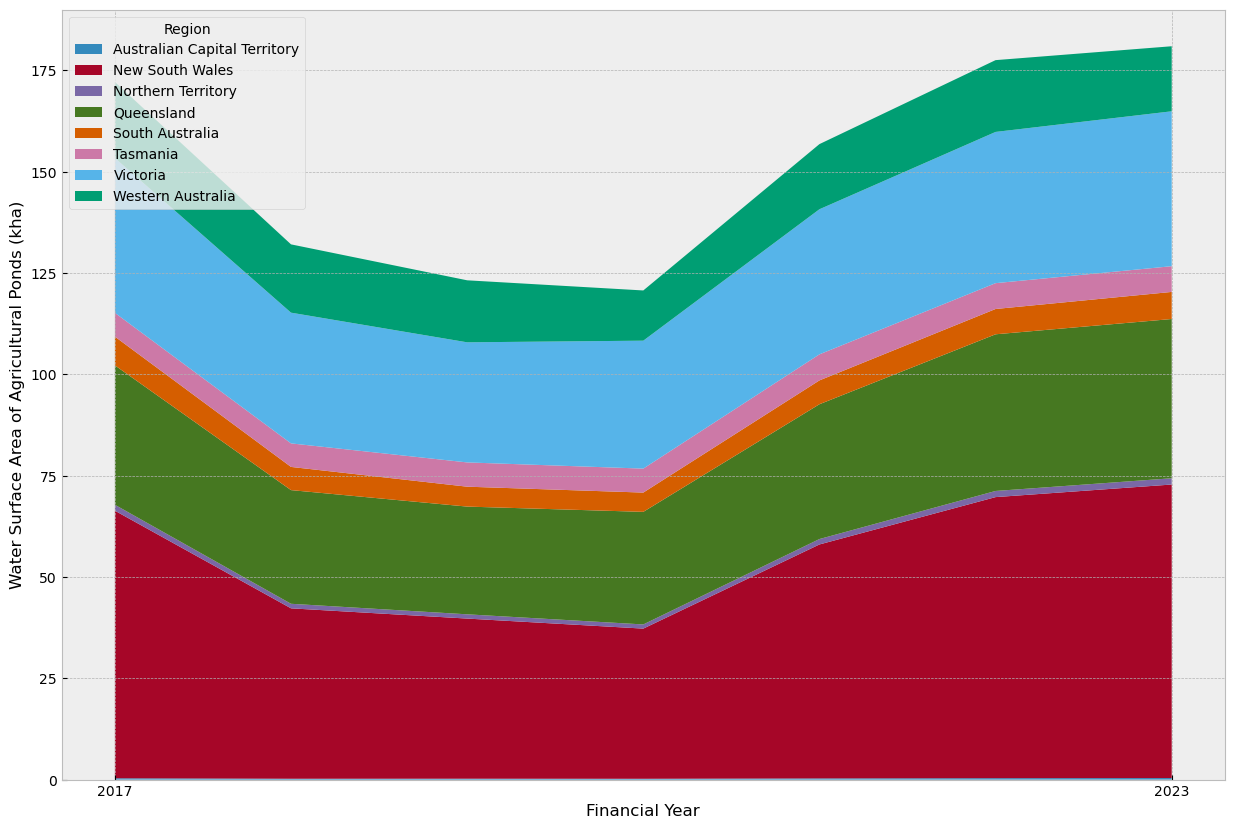

In [90]:
# ========
# FIGURE 3: Total water surface devided by State and Territories
# ========
# Create a list of unique years, stepping by 6
fin_year_breaks = Data9["FinYear"].unique()[::6]
# Pivot the data for stacked area plot
pivot_df = Data9.pivot(
    index="FinYear", columns="NAME", values="SumArea.kha.AdjCoef.ecd"
).fillna(0)
fig, ax = plt.subplots(figsize=(15, 10))  # Adjust the size as needed
# Create the stacked area plot
ax.stackplot(pivot_df.index, pivot_df.T)
# Add labels and legend
ax.set_xlabel("Financial Year")
ax.set_ylabel("Water Surface Area of Agricultural Ponds (kha)")
ax.legend(pivot_df.columns, loc="upper left", title="Region")  # Add title to the legend
# Set xticks
ax.set_xticks(fin_year_breaks)
# Save the plot
plt.savefig(plots_dir / "TotWaterSurface.pdf", format="pdf", dpi=300)
# Show the plot
plt.show()

In [91]:
# Stats
# Relative magnitude of year-to-year variability
SA_YearToYear_Rel = (
    Data10["SumArea.kha.AdjCoef"].diff() / Data10["SumArea.kha.AdjCoef"].shift()
)
print(
    "Mean of absolute relative year-to-year changes:",
    100 * SA_YearToYear_Rel.abs().mean(),
)
print(
    "Max of absolute relative year-to-year changes:",
    100 * SA_YearToYear_Rel.abs().max(),
)

# Absolute difference
SA_YearToYear = Data10["SumArea.kha.AdjCoef"].diff()
print("Mean of absolute year-to-year changes:", SA_YearToYear.abs().mean())
print("Max of absolute year-to-year changes:", SA_YearToYear.abs().max())

Mean of absolute relative year-to-year changes: 15.041001747651661
Max of absolute relative year-to-year changes: 29.373109565288736
Mean of absolute year-to-year changes: 21.853197946659936
Max of absolute year-to-year changes: 41.120430035330486


SECTION 4

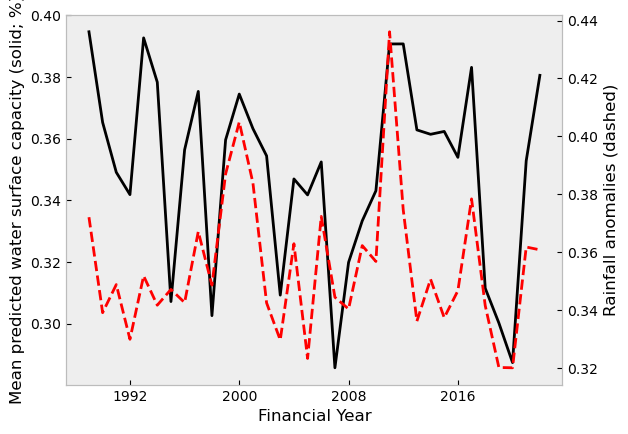

Pearson's correlation: r = 0.5719381524271262


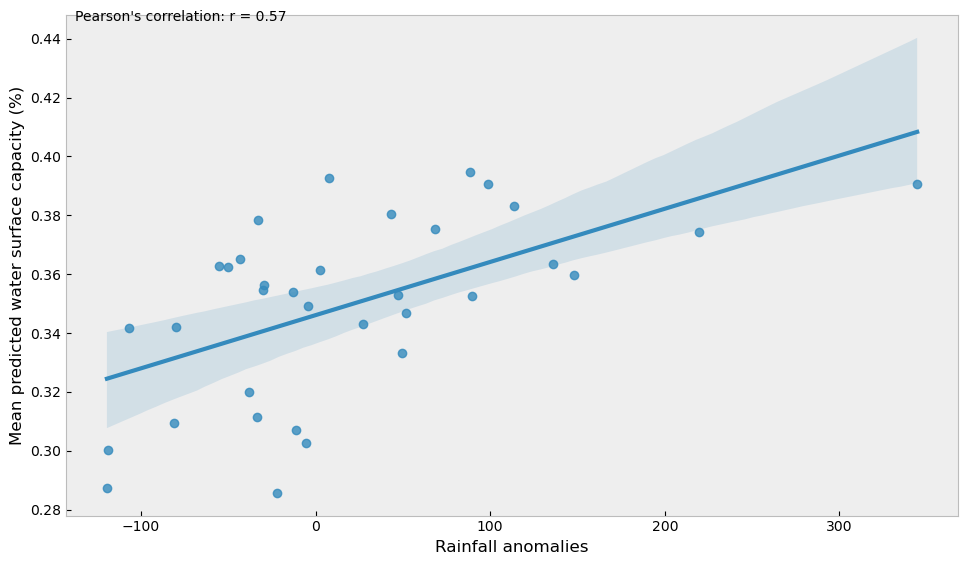

In [92]:
## =============
## FIGURE 4: COMPARE SURFACE AREA TO RAINFALL ANOMALIES FROM BOM
## =============
# (1) Load relative capacity
RelCapacity = pd.read_csv(required_data / "RelCapacity.csv")
# (2) Load rainfall anomalies
# -----
# Website sourced: http://www.bom.gov.au/climate/change/#tabs=Tracker&tracker=timeseries&tQ=graph%3Drranom%26area%3Daus%26season%3D0706%26ave_yr%3D0
RainAnomalies = pd.read_csv(
    required_data / "Rainfall anomalies.txt",
    # delim_whitespace=True,
    sep="\s+",
    names=["FinYear", "Anomaly"],
)

# Format the years by extracting the correct segment
RainAnomalies["FinYear"] = RainAnomalies["FinYear"].astype(str).str[6:10].astype(int)

# Subset for complete years (filtering the years to match specific range)
# i.e. those with 120 observations using table(Data6['FinYear'])
RainAnomalies_sub = RainAnomalies[
    (RainAnomalies["FinYear"] >= 1989) & (RainAnomalies["FinYear"] <= 2022)
]

# New dataset with relative water capacity and BOM anomalies
RelCapacity["FinYear"] = RelCapacity["FinYear"]
RelCapacity = RelCapacity.rename(columns={"NAME": "State"})
RelCapacityBOM = (
    RelCapacity.groupby(["FinYear", "State"])
    .agg({"RelSurfaceArea": "mean"})
    .reset_index()
)

# Averaged across Aus
RelCapacity.rename(columns={"NAME": "State"}, inplace=True)
RelCapacityBOM_aus = RelCapacity.groupby("FinYear", as_index=False).agg(
    {"RelSurfaceArea": "mean"}
)
RelCapacityBOM_aus = pd.merge(
    RelCapacityBOM_aus, RainAnomalies_sub, on="FinYear", how="inner"
)

# Save the data
# RelCapacityBOM.to_pickle(required_data / "RelCapacityBOM.RData")
# RelCapacityBOM_aus.to_pickle(required_data / "RelCapacityBOM.aus.RData")

# RelCapacityBOM.head()
# RelCapacityBOM_aus.head()

# Lineplot of average relative capacity and BOM rainfall anomalies
fig, ax1 = plt.subplots()

# Plot the mean predicted water surface capacity on the first y-axis
ax1.plot(
    RelCapacityBOM_aus["FinYear"], RelCapacityBOM_aus["RelSurfaceArea"], color="black"
)
ax1.set_xlabel("Financial Year")
ax1.set_ylabel("Mean predicted water surface capacity (solid; %)")

# Create a second y-axis and plot the rainfall anomalies on it
ax2 = ax1.twinx()
ax2.plot(
    RelCapacityBOM_aus["FinYear"],
    (RelCapacityBOM_aus["Anomaly"] / 4000) + 0.35,
    color="red",
    linestyle="dashed",
)
ax2.set_ylabel("Rainfall anomalies (dashed)")

# Set the number of ticks on the x-axis
ax1.xaxis.set_major_locator(plt.MaxNLocator(6))

# Hide the grid lines
ax1.grid(False)
ax2.grid(False)

# Save the plot
plt.savefig(plots_dir / "Predict.Plot.area.tot1.T4.pdf")

plt.show()

# Check correlation
correlation, _ = pearsonr(
    RelCapacityBOM_aus["RelSurfaceArea"], RelCapacityBOM_aus["Anomaly"]
)
print(f"Pearson's correlation: r = {correlation}")

# Scatterplot of average relative capacity and BOM rainfall anomalies
plt.figure(figsize=(11.5, 6.5))
sns.regplot(x="Anomaly", y="RelSurfaceArea", data=RelCapacityBOM_aus)
plt.xlabel("Rainfall anomalies")
plt.ylabel("Mean predicted water surface capacity (%)")
plt.grid(False)
plt.text(-138, 0.446, f"Pearson's correlation: r = {correlation:.2f}")

# Save the plot
plt.savefig(plots_dir / "Predict.Plot.area.tot2.T4.pdf")

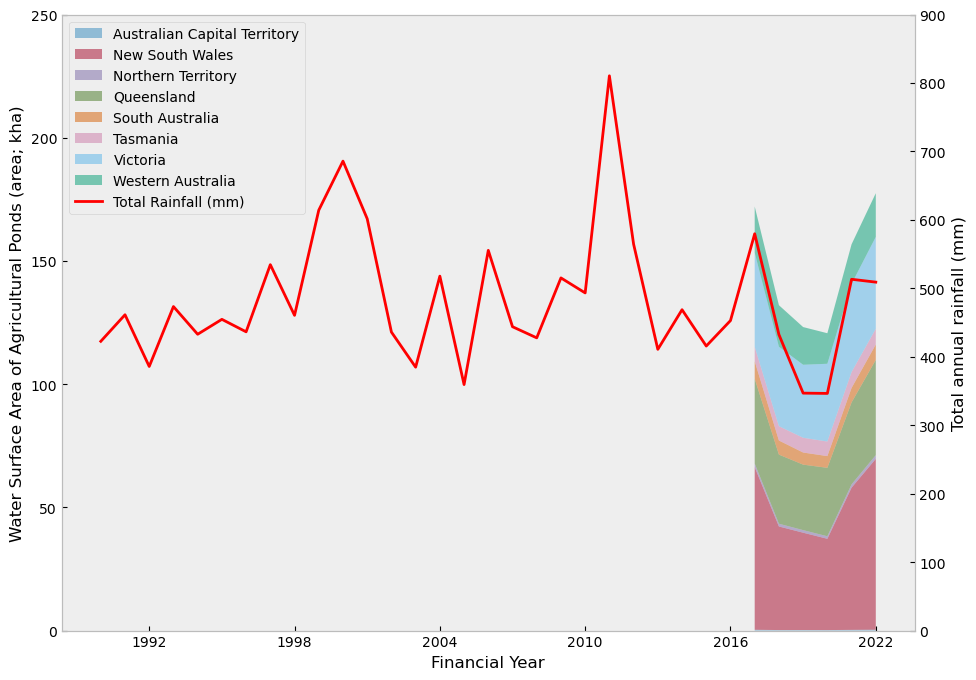

In [93]:
# ========
# Add total rainfall to the total water surface devided by State and Territories (Fig3)
# ========

# Get data on total rainfall
# Website sourced: http://www.bom.gov.au/climate/change/#tabs=Tracker&tracker=timeseries&tQ=graph%3Drranom%26area%3Daus%26season%3D0706%26ave_yr%3D0
# Load the datasets
TotalRain = pd.read_csv(required_data / "Total rainfall.csv")
TotalRain.rename(columns={"Total Rainfall": "TotRain"}, inplace=True)
TotalRain = TotalRain[(TotalRain["FinYear"] > 1989) & (TotalRain["FinYear"] < 2023)]

# We used Data 9 here. Load Data9 if not already loaded
Data9["FinYear"] = pd.to_numeric(Data9["FinYear"], errors="coerce")
Data9 = Data9[(Data9["FinYear"] > 1989) & (Data9["FinYear"] < 2023)]

# Plotting
fig, ax1 = plt.subplots(figsize=(11, 8))
# Get unique names
names = Data9["NAME"].unique()
# Create a list of data for each name
y = [Data9[Data9["NAME"] == name]["SumArea.kha.AdjCoef.ecd"].values for name in names]
# Stacked area plot for Water Surface Area
ax1.stackplot(Data9["FinYear"].unique(), y, labels=names, alpha=0.5)

# Line plot for Total Rainfall
ax2 = ax1.twinx()
ax2.plot(
    TotalRain["FinYear"], TotalRain["TotRain"], color="red", label="Total Rainfall (mm)"
)

# Setting labels
ax1.set_xlabel("Financial Year")
ax1.set_ylabel("Water Surface Area of Agricultural Ponds (area; kha)")
ax2.set_ylabel("Total annual rainfall (mm)")

# Set the limits of the primary and secondary y-axis
ax1.set_ylim(0, 250)
ax2.set_ylim(0, 900)

# Customize ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(6))
# Grid and legend
ax1.grid(False)
ax2.grid(False)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(0, 1)
)

# Save and display the plot
plt.savefig(plots_dir / "TotWaterSurfaceRain.pdf")
plt.show()

SECTION 5

In [94]:
## =============
## FIGURE 5: COMPARE EMISSION FACTORS ACROSS TIERS
## =============
# X axis: temperature
# Y axis: emissions
# Colour: Tier 1, 2, and 3

# Create the dataset
TierComp = pd.DataFrame({"Temp": range(51)})

# Get temp-sensitivity (from Boltzmann.lm)
Boltzmann_lm_df = pd.DataFrame(
    {"Fixef": [0.4287063], "LCI": [0.2143579], "UCI": [0.6430547]}
)

# Get the Boltzmann coefficient
Boltzmann_const_evK = 8.617333262145 * 1e-5

# Get Boltzmann factor across temps
TierComp["Boltzmann_15C"] = (1 / (Boltzmann_const_evK * (273.15 + 15))) - (
    1 / (Boltzmann_const_evK * (273.15 + TierComp["Temp"]))
)

# Load the average farm dam emissions at 15C in mg.m2.day (from TotMet_15C.lm)
TotMet_15C_lm_df = pd.DataFrame(
    {"Fixef": [1.74705], "LCI": [1.354771], "UCI": [2.1546436]}
)

# Get average emission factor
FarmDams_CH4kgyearha_at15C = 365.25 * 10000 * (10 ** TotMet_15C_lm_df["Fixef"][0]) / 1e6
FarmDams_CH4kgyearha_at15C_LCI = (
    365.25 * 10000 * (10 ** TotMet_15C_lm_df["LCI"][0]) / 1e6
)
FarmDams_CH4kgyearha_at15C_UCI = (
    365.25 * 10000 * (10 ** TotMet_15C_lm_df["UCI"][0]) / 1e6
)

# Get emissions T3 (kt.year.ha)
# ------
TierComp["EF_T3"] = (
    np.exp(
        float(Boltzmann_lm_df["Fixef"].iloc[0]) * TierComp["Boltzmann_15C"]
        + np.log(float(FarmDams_CH4kgyearha_at15C))
    )
    * 1000
    / 1000000
)
TierComp["EF_T3_LCI"] = (
    np.exp(
        float(Boltzmann_lm_df["LCI"].iloc[0]) * TierComp["Boltzmann_15C"]
        + np.log(float(FarmDams_CH4kgyearha_at15C_LCI))
    )
    * 1000
    / 1000000
)
TierComp["EF_T3_UCI"] = (
    np.exp(
        float(Boltzmann_lm_df["UCI"].iloc[0]) * TierComp["Boltzmann_15C"]
        + np.log(float(FarmDams_CH4kgyearha_at15C_UCI))
    )
    * 1000
    / 1000000
)

# All in one equation
TierComp["EF_T3_AllInOne"] = (
    np.exp(
        0.4287063
        * (
            (1 / (8.617333e-05 * (273.15 + 15)))
            - (1 / (8.617333e-05 * (273.15 + TierComp["Temp"])))
        )
        + 5.318143
    )
    * 1000
    / 1000000
)

# Get emissions T1 (kt.year.ha)
# ------
TierComp["EF_T1"] = 183 * 1000 / 1000000
TierComp["EF_T1_LCI"] = 118 * 1000 / 1000000
TierComp["EF_T1_UCI"] = 228 * 1000 / 1000000

# Get emissions T2, climate-specific EF following Tertius directions (Kg CH4 ha-1 year-1)
# ------
# Load data
Tier2EF_dict = pd.read_excel(
    required_data / "EF and climate zone dictionary.xlsx", sheet_name="Restructure2"
)
Tier2EF_dict["EF_T2.kt"] = Tier2EF_dict["EF_T2"] * 1000 / 1000000
Tier2EF_dict["Climate"] = Tier2EF_dict["Climate"].astype("category")

# Merge data
TierComp2 = pd.merge(Tier2EF_dict, TierComp, on="Temp", how="outer")
# Extract the CI from the relationship
T2_raw = pd.read_excel(
    required_data / "Farmdam EF values_COPY.xlsx", sheet_name="Working data set_R"
)


# Define the model
def model(Temp, a, b):
    return a * Temp**b


# Fit the model
popt, pcov = curve_fit(
    model, T2_raw["Temp"], np.log10(T2_raw["EF_kg.CH4.ha.y"]), p0=[0.9, 2]
)
# Predict
T2_raw["pred"] = model(T2_raw["Temp"], *popt)

# Calculate prediction intervals
residuals = np.log10(T2_raw["EF_kg.CH4.ha.y"]) - T2_raw["pred"]
sse = np.sum(residuals**2)
mse = sse / (len(T2_raw) - len(popt))

# Calculate the prediction interval
t_value = stats.t.ppf(0.975, len(T2_raw) - len(popt))
pi = t_value * np.sqrt((1 / len(T2_raw)) * mse)

# Add the prediction interval to the data frame
T2_raw["lower"] = T2_raw["pred"] - pi
T2_raw["upper"] = T2_raw["pred"] + pi

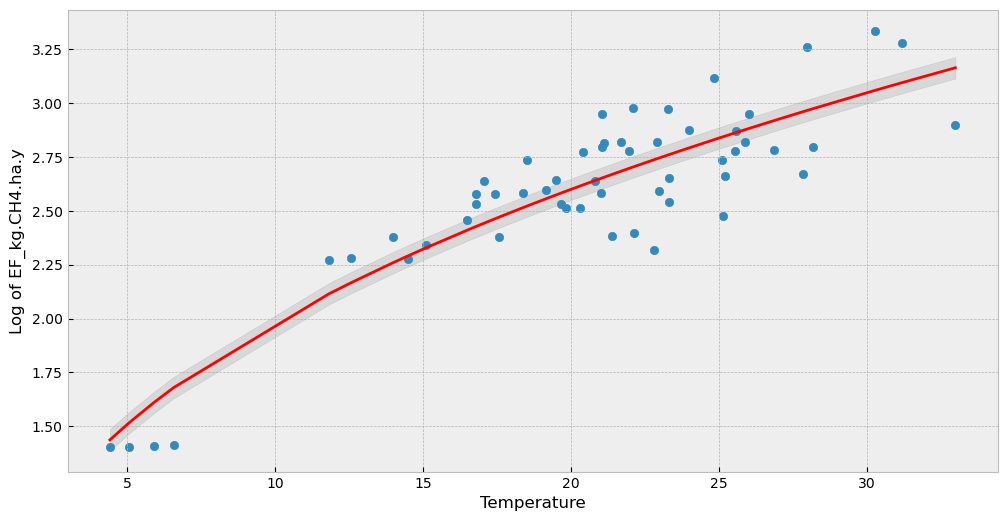

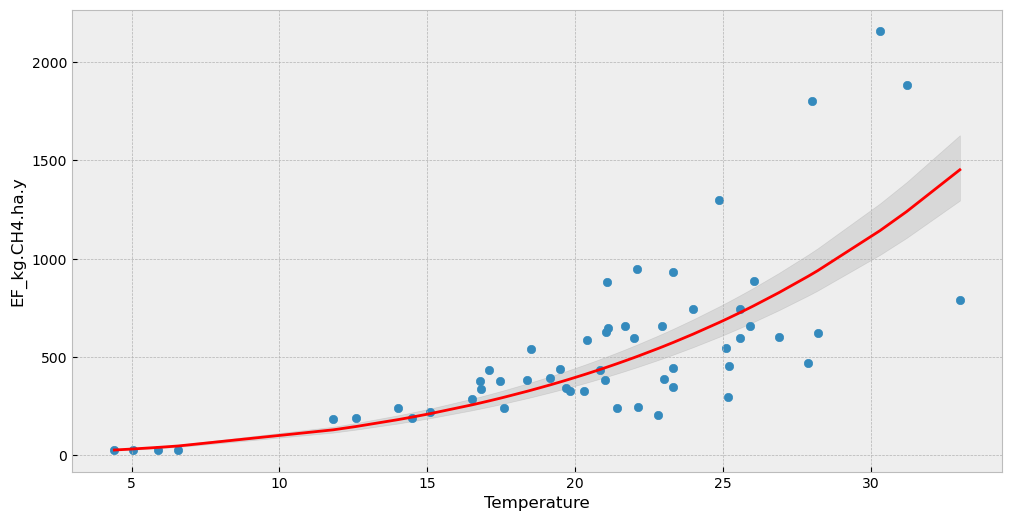

In [95]:
# Plot log-scale
plt.figure(figsize=(12, 6))
plt.plot(T2_raw["Temp"], T2_raw["pred"], "r")
plt.fill_between(
    T2_raw["Temp"], T2_raw["lower"], T2_raw["upper"], color="gray", alpha=0.2
)
plt.scatter(T2_raw["Temp"], np.log10(T2_raw["EF_kg.CH4.ha.y"]))
plt.xlabel("Temperature")
plt.ylabel("Log of EF_kg.CH4.ha.y")
plt.show()

# plot arithmetic version
plt.figure(figsize=(12, 6))
plt.plot(T2_raw["Temp"], 10 ** T2_raw["pred"], "r")
plt.fill_between(
    T2_raw["Temp"],
    10 ** T2_raw["lower"],
    10 ** T2_raw["upper"],
    color="gray",
    alpha=0.2,
)
plt.scatter(T2_raw["Temp"], T2_raw["EF_kg.CH4.ha.y"])
plt.xlabel("Temperature")
plt.ylabel("EF_kg.CH4.ha.y")
plt.show()

In [96]:
# Check for patterns
print(T2_raw["lower"] / T2_raw["pred"])
print(T2_raw["upper"] / T2_raw["pred"])
print(T2_raw["pred"] / T2_raw["upper"])
# Averages
print(np.mean(T2_raw["lower"] / T2_raw["pred"]))
print(np.mean(T2_raw["upper"] / T2_raw["pred"]))

0     0.965525
1     0.967280
2     0.969237
3     0.970505
4     0.976559
5     0.977125
6     0.978064
7     0.978358
8     0.978705
9     0.979433
10    0.979573
11    0.979578
12    0.979710
13    0.979875
14    0.979938
15    0.980285
16    0.980344
17    0.980604
18    0.980737
19    0.980803
20    0.980864
21    0.981042
22    0.981075
23    0.981226
24    0.981292
25    0.981303
26    0.981310
27    0.981331
28    0.981427
29    0.981525
30    0.981621
31    0.981660
32    0.981670
33    0.981883
34    0.981923
35    0.981942
36    0.982036
37    0.982039
38    0.982042
39    0.982241
40    0.982484
41    0.982553
42    0.982567
43    0.982583
44    0.982677
45    0.982682
46    0.982764
47    0.982800
48    0.983015
49    0.983252
50    0.983285
51    0.983329
52    0.983795
53    0.983980
54    0.984328
dtype: float64
0     1.034475
1     1.032720
2     1.030763
3     1.029495
4     1.023441
5     1.022875
6     1.021936
7     1.021642
8     1.021295
9     1.020567
10    1.02

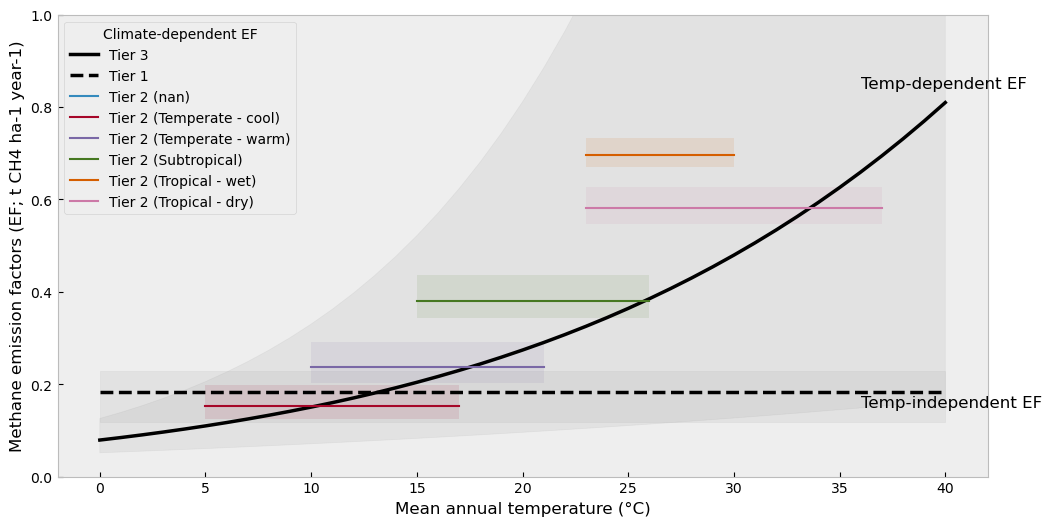

In [97]:
# Solution:
# For the LCI, I will multiply the predicted log-10 value by 0.8432157 for R/But 0.9803596 for Python
# For the UCI, I will multiply the predicted log-10 value by 1.100405 for R/But 1.0196403 for python
TierComp2["EF_T2.kt_UCI"] = 10 ** (np.log10(TierComp2["EF_T2.kt"]) * 0.8604673)
TierComp2["EF_T2.kt_LCI"] = 10 ** (np.log10(TierComp2["EF_T2.kt"]) * 1.1085)

# Filter data
TierComp2_filtered = TierComp2[TierComp2["Temp"] < 41]

# Plot
plt.figure(figsize=(12, 6))

# Calculate the mean of 'EF_T3', 'EF_T3_LCI', and 'EF_T3_UCI' for each temperature
Tier3_data = (
    TierComp2_filtered.groupby("Temp")
    .agg({"EF_T3": "mean", "EF_T3_LCI": "mean", "EF_T3_UCI": "mean"})
    .reset_index()
)

# Tier 3 ribbon and line
plt.fill_between(
    Tier3_data["Temp"],
    Tier3_data["EF_T3_LCI"],
    Tier3_data["EF_T3_UCI"],
    color="gray",
    alpha=0.1,
)
plt.plot(Tier3_data["Temp"], Tier3_data["EF_T3"], "k", linewidth=2.5, label="Tier 3")

# Calculate the mean of 'EF_T1', 'EF_T1_LCI', and 'EF_T1_UCI' for each temperature
Tier1_data = (
    TierComp2_filtered.groupby("Temp")
    .agg({"EF_T1": "mean", "EF_T1_LCI": "mean", "EF_T1_UCI": "mean"})
    .reset_index()
)

# Tier 1 ribbon and line
plt.fill_between(
    Tier1_data["Temp"],
    Tier1_data["EF_T1_LCI"],
    Tier1_data["EF_T1_UCI"],
    color="gray",
    alpha=0.1,
)
plt.plot(Tier1_data["Temp"], Tier1_data["EF_T1"], "k--", linewidth=2.5, label="Tier 1")

# Tier 2 ribbon and line for each climate
for climate in TierComp2_filtered["Climate"].unique():
    data = TierComp2_filtered[TierComp2_filtered["Climate"] == climate]
    plt.fill_between(
        data["Temp"], data["EF_T2.kt_LCI"], data["EF_T2.kt_UCI"], alpha=0.1
    )
    plt.plot(data["Temp"], data["EF_T2.kt"], linewidth=1.5, label=f"Tier 2 ({climate})")

plt.ylim(0, 1)
plt.xlabel("Mean annual temperature (°C)")
plt.ylabel("Methane emission factors (EF; t CH4 ha-1 year-1)")
plt.legend(title="Climate-dependent EF", loc="upper left")

plt.text(36, 0.84, "Temp-dependent EF", fontsize=12)
plt.text(36, 0.15, "Temp-independent EF", fontsize=12)

# Remove grid lines
plt.grid(False)

In [98]:
# Save plot
plt.savefig(plots_dir / "Emission factors.pdf")
plt.savefig(plots_dir / "Emission factors.jpeg")

# Save data
# TierComp2.to_pickle(required_data / "TierComp2.pkl")

<Figure size 640x480 with 0 Axes>

SECTION 6

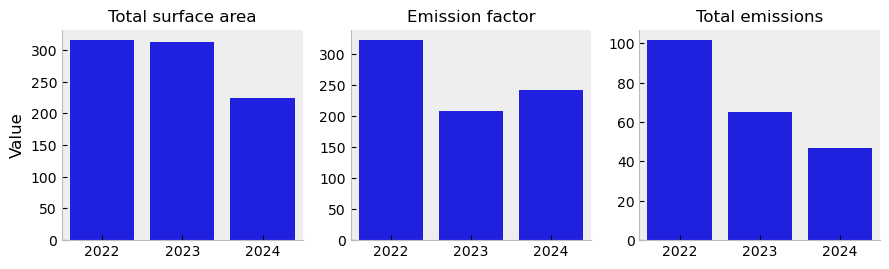

In [99]:
## =============
## FIGURE 6: Compare estimates from the NIR reports
## =============
# Load the data
NIRcomp = pd.read_excel(required_data / "NIR comparison.xlsx")

# Ensure 'Variable' is a categorical variable with specific order
NIRcomp["Variable"] = pd.Categorical(
    NIRcomp["Variable"],
    categories=["Total surface area", "Emission factor", "Total emissions"],
    ordered=True,
)

# Plot
g = sns.FacetGrid(
    NIRcomp,
    col="Variable",
    col_order=["Total surface area", "Emission factor", "Total emissions"],
    sharey=False,
)
g.map_dataframe(sns.barplot, x="Year", y="Value", color="b")

# Remove grid lines and set background to white
g.set_axis_labels("", "Value")
g.set_titles("{col_name}")
g.fig.subplots_adjust(wspace=0.2)

for ax in g.axes.flat:
    ax.grid(False)  # Turn off grid

plt.show()
# Save plot
g.savefig(plots_dir / "NIRcomp.plot.pdf")

SECTION 7

MAE: 0.06046148857112542 ha
MAPE: 42.10239832444439%
Correlation: 0.7863693723086999


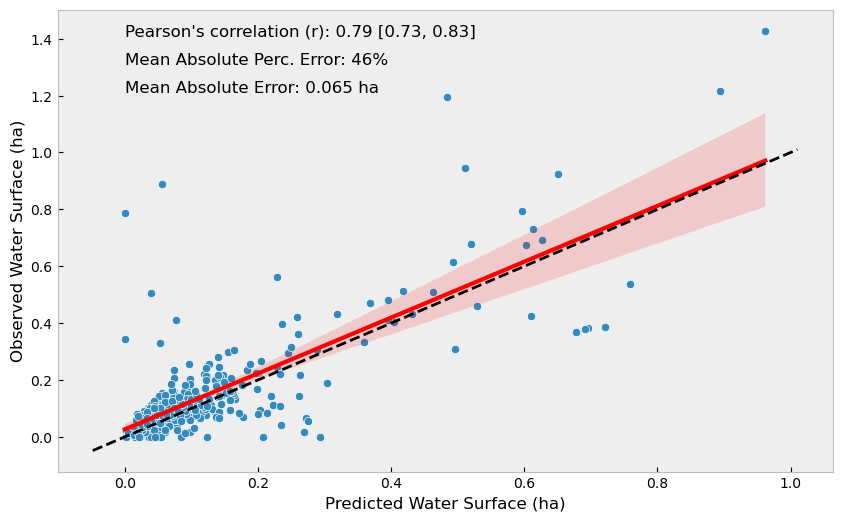

In [100]:
## =============
## FIGURE 7: Sources of uncertainty
## =============
# ------
# Average total methane emission at 15C
# ------
# Load the average farm dam emissions at 15C in mg.m2.day (from TotMet_15C.lm)
# We already did in section 5 when we compared emission factors accross Tiers but you can create it agian as done below
# Create the data frame
TotMet_15C_lm_df = pd.DataFrame(
    {"Fixef": [1.74705], "LCI": [1.354771], "UCI": [2.1546436]}
)

# Convert from mg.m2.day to kg.ha.year
FarmDams_CH4kgyearha_at15C = 365.25 * 10000 * (10 ** TotMet_15C_lm_df["Fixef"]) / 1e6
FarmDams_CH4kgyearha_at15C_LCI = 365.25 * 10000 * (10 ** TotMet_15C_lm_df["LCI"]) / 1e6
FarmDams_CH4kgyearha_at15C_UCI = 365.25 * 10000 * (10 ** TotMet_15C_lm_df["UCI"]) / 1e6

# CV for the relative error
Emissions_LCI = (
    FarmDams_CH4kgyearha_at15C - FarmDams_CH4kgyearha_at15C_LCI
) / FarmDams_CH4kgyearha_at15C
Emissions_UCI = (
    FarmDams_CH4kgyearha_at15C_UCI - FarmDams_CH4kgyearha_at15C
) / FarmDams_CH4kgyearha_at15C
Emissions_CV = np.mean([Emissions_LCI.values[0], Emissions_UCI.values[0]])

# -------
# Farm dam area (more details in "Download time series from Waterbodies" folder)
# -------
# Load the data
AllValidation = pd.read_csv(required_data / "AllValidation.csv")

# MAE: Mean Absolute Error (ha)
MAE = mae(AllValidation["Obs"], AllValidation["Pred"]) * 0.0001
print(f"MAE: {MAE} ha")  # 0.06ha

# MAPE: Mean Absolute Percent Error
MAPE = (
    mae(AllValidation["Obs"], AllValidation["Pred"]) / AllValidation["Obs"].mean() * 100
)
print(f"MAPE: {MAPE}%")  # 42%

# Correlation test
correlation, _ = stats.pearsonr(AllValidation["Obs"], AllValidation["Pred"])
print(f"Correlation: {correlation}")  # r = 0.79

# Calculate prediction intervals
# Fit the model
Val_lm = smf.ols(formula="Obs ~ Pred", data=AllValidation).fit()
# Predict the values
predictions = Val_lm.get_prediction(AllValidation)
predictions_summary_frame = predictions.summary_frame()
# Create a new DataFrame with the intervals
AllValidation_predint = pd.concat([AllValidation, predictions_summary_frame], axis=1)

# plot the data
# Create a new figure
plt.figure(figsize=(10, 6))

# Scatter plot of Observed vs Predicted Water Surface
sns.scatterplot(
    data=AllValidation_predint,
    x=AllValidation_predint["Pred"] * 0.0001,
    y=AllValidation_predint["Obs"] * 0.0001,
)

# Linear regression with confidence interval
sns.regplot(
    data=AllValidation_predint,
    x=AllValidation_predint["Pred"] * 0.0001,
    y=AllValidation_predint["Obs"] * 0.0001,
    color="red",
    scatter=False,
    ci=95,
    line_kws={"color": "red"},
)

# Add labels and remove grid
plt.xlabel("Predicted Water Surface (ha)")
plt.ylabel("Observed Water Surface (ha)")
plt.grid(False)

# Add annotations
plt.text(
    0 * 0.0001,
    14100 * 0.0001,
    "Pearson's correlation (r): 0.79 [0.73, 0.83]",
    fontsize=12,
)
plt.text(0 * 0.0001, 13100 * 0.0001, "Mean Absolute Perc. Error: 46%", fontsize=12)
plt.text(0 * 0.0001, 12100 * 0.0001, "Mean Absolute Error: 0.065 ha", fontsize=12)

# Fit the 1:1 line to the data
x = np.linspace(plt.xlim()[0], plt.xlim()[1], 100)
y = x
plt.plot(x, y, "k--")

# Save the plot
plt.savefig(plots_dir / "Validation weather-to-water_new.jpeg")
plt.savefig(plots_dir / "Validation weather-to-water_new..pdf")
# Decide on a CV
FarmDamArea_CV = 0.42

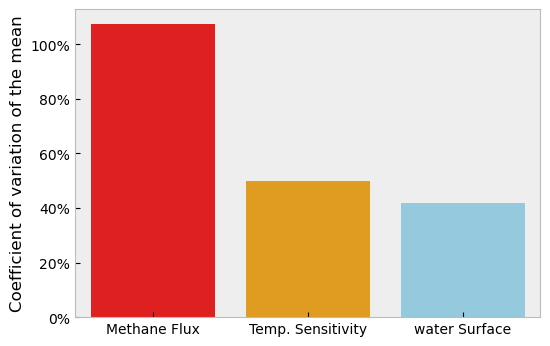

In [101]:
# -------
# Temp sensitivity
# -------
# Create DataFrame
Boltzmann_lm_df = pd.DataFrame(
    {"Fixef": [0.4287063], "LCI": [0.2143579], "UCI": [0.6430547]}
)

# Calculate TempEmissions and CV
TempEmissions = {
    "mean": Boltzmann_lm_df.loc[0, "Fixef"],
    "LCI": Boltzmann_lm_df.loc[0, "LCI"],
    "UCI": Boltzmann_lm_df.loc[0, "UCI"],
}
TempEmissions["CV_LCI"] = (
    TempEmissions["mean"] - TempEmissions["LCI"]
) / TempEmissions["mean"]
TempEmissions["CV_UCI"] = (
    TempEmissions["UCI"] - TempEmissions["mean"]
) / TempEmissions["mean"]
TempEmissions["CV"] = (TempEmissions["CV_UCI"] + TempEmissions["CV_LCI"]) / 2

# All CVs
CV = {
    "Methane Flux": Emissions_CV,
    "Temp. Sensitivity": TempEmissions["CV"],
    "water Surface": FarmDamArea_CV,
}

# Create DataFrame
AllCV = pd.DataFrame(list(CV.items()), columns=["labels", "CV"])
AllCV["CV_std"] = AllCV["CV"] / AllCV["CV"].sum()

# Save DataFrame
AllCV.to_pickle(required_data / "AllCV.pkl")

# Define color palette
palette = ["red", "orange", "skyblue"]

# Plot sources of uncertainty
plt.figure(figsize=(6, 4))
for i, label in enumerate(AllCV["labels"]):
    sns.barplot(
        data=AllCV[AllCV["labels"] == label], x="labels", y="CV", color=palette[i]
    )
plt.xlabel("")
plt.ylabel("Coefficient of variation of the mean")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(False)

# Save plot
plt.savefig(plots_dir / "CV.pdf")
plt.savefig(plots_dir / "CV.jpeg")

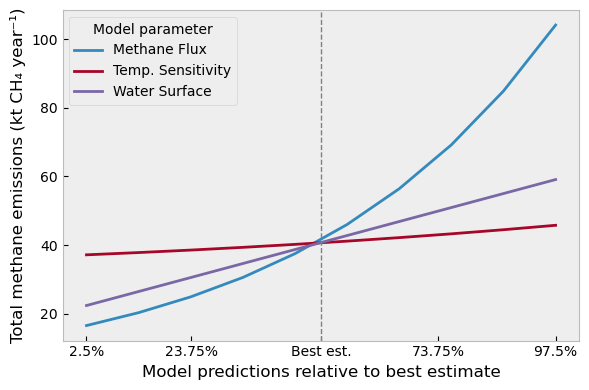

<Figure size 640x480 with 0 Axes>

In [102]:
## =============
## Spider plots
## =============
# Load the data from the sensitivity analysis
Data_loop2 = pd.read_excel(required_data / "Data_loop2.xlsx", sheet_name="Reformat")

# Correct the column name to match Python's variable naming conventions (replace dots with underscores)
Data_loop2.columns = [col.replace(".", "_") for col in Data_loop2.columns]

# Create the Spider plot
plt.figure(figsize=(6, 4))
sns.lineplot(
    data=Data_loop2, x="CI", y="TotCH4_ktyear_AdjCoef_ecd", hue="Par", errorbar=None
)

# Customize the plot
plt.legend(title="Model parameter", bbox_to_anchor=(0.35, 1))
plt.grid(False)  # Turn off the grid
plt.xlabel("Model predictions relative to best estimate")
plt.ylabel("Total methane emissions (kt CH₄ year⁻¹)")
plt.xticks(
    ticks=[0.025, 0.2375, 0.5, 0.7375, 0.975],
    labels=["2.5%", "23.75%", "Best est.", "73.75%", "97.5%"],
)

# Optional: Add a vertical dashed line at the 'Best est.' mark
plt.axvline(x=0.5, color="gray", linestyle="dashed", linewidth=1)

# Show the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

# Save the plot
plt.savefig(plots_dir / "Spider.jpeg")
plt.savefig(plots_dir / "Spider.pdf")

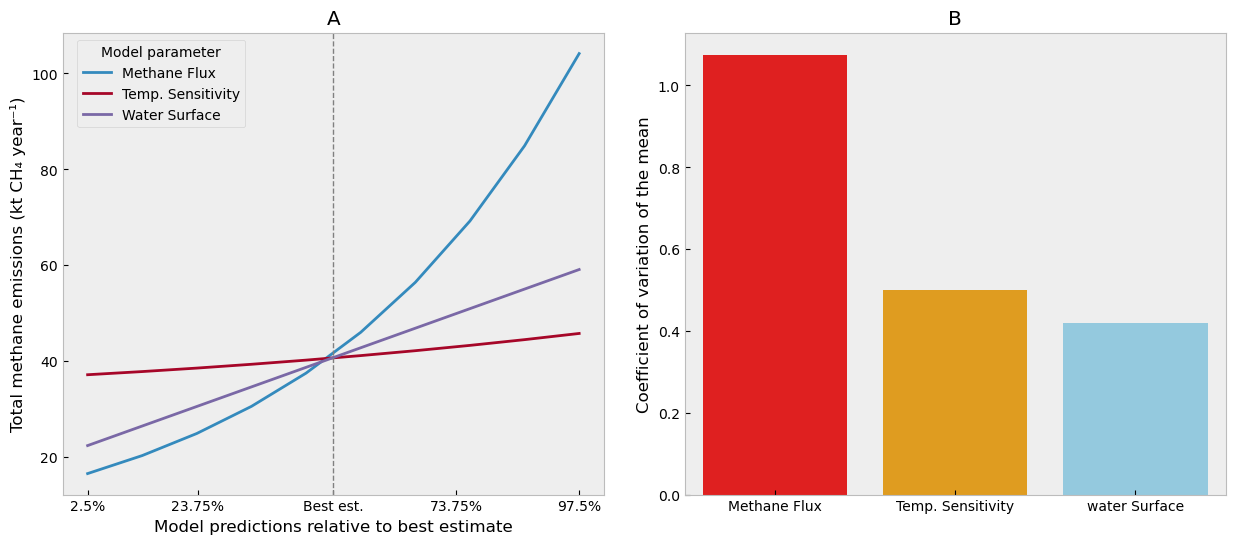

In [103]:
# Combine the plots and save it
def spider_plot(ax):
    Data_loop2.columns = [col.replace(".", "_") for col in Data_loop2.columns]
    sns.lineplot(
        data=Data_loop2,
        x="CI",
        y="TotCH4_ktyear_AdjCoef_ecd",
        hue="Par",
        ax=ax,
        errorbar=None,
    )
    ax.set_xlabel("Model predictions relative to best estimate")
    ax.set_ylabel("Total methane emissions (kt CH₄ year⁻¹)")
    ax.legend(title="Model parameter", bbox_to_anchor=(0.35, 1))
    ax.grid(False)
    ax.axvline(x=0.5, color="gray", linestyle="dashed", linewidth=1)
    ax.set_xticks([0.025, 0.2375, 0.5, 0.7375, 0.975])
    ax.set_xticklabels(["2.5%", "23.75%", "Best est.", "73.75%", "97.5%"])


def cv_plot(ax):
    palette = ["red", "orange", "skyblue"]
    for i, label in enumerate(AllCV["labels"].unique()):
        sns.barplot(
            data=AllCV[AllCV["labels"] == label],
            x="labels",
            y="CV",
            color=palette[i],
            ax=ax,
        )
    ax.set_xlabel("")
    ax.set_ylabel("Coefficient of variation of the mean")
    ax.grid(False)


# Create figure and axes
fig = plt.figure(figsize=(15, 6))
gs = GridSpec(1, 2, figure=fig)
# Create Spider plot on the left
ax1 = fig.add_subplot(gs[0, 0])
spider_plot(ax1)
ax1.set_title("A")
# Create CV plot on the right
ax2 = fig.add_subplot(gs[0, 1])
cv_plot(ax2)
ax2.set_title("B")
# Adjust subplots
plt.subplots_adjust(wspace=0.15)
# Save the figure
plt.savefig(plots_dir / "SpiderCV.pdf")
plt.savefig(plots_dir / "SpiderCV.jpeg")
# Show the combined plots
plt.show()

SECTION 8

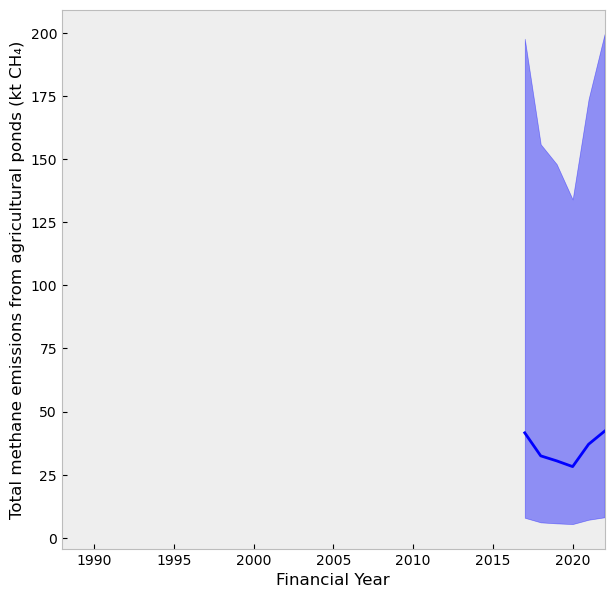

In [104]:
## =============
## FIGURE 8: Total methane emissions
## =============
# Set up the plot
plt.figure(figsize=(7, 7))
plt.style.use("bmh")
# Plot the line for total methane emissions
sns.lineplot(
    data=Data10, x="FinYear", y="TotCH4.ktyear.AdjCoef.ecd", legend=False, color="b"
)

# Add a ribbon for confidence intervals
plt.fill_between(
    Data10["FinYear"],
    Data10["TotCH4.ktyear_LCI.AdjCoef.ecd"],
    Data10["TotCH4.ktyear_UCI.AdjCoef.ecd"],
    color="blue",
    alpha=0.4,
)

# Customizing the plot
plt.xlabel("Financial Year")
plt.ylabel("Total methane emissions from agricultural ponds (kt CH₄)")
plt.xlim(1988, 2022)
plt.grid(False)
# plt.title("Total Methane Emissions Visualization")  # Optional: add a title

# Save the plot
plt.savefig(plots_dir / "TotEmissions_Aus.pdf")
plt.savefig(plots_dir / "TotEmissions_Aus.jpeg")

# Show the plot
plt.show()

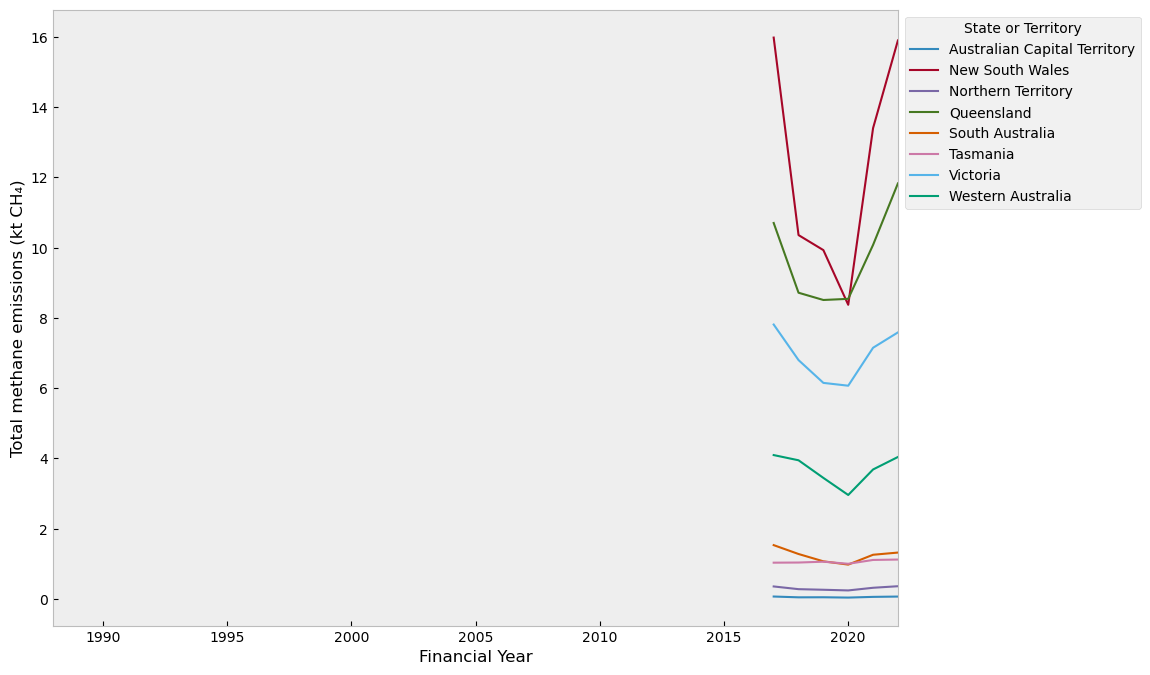

In [105]:
# plot On the same graph as different lines
# Set up the plot
plt.figure(figsize=(10.9, 8))
plt.style.use("bmh")

# Plotting lines for each state or territory
sns.lineplot(
    data=Data9, x="FinYear", y="TotCH4.ktyear.AdjCoef.ecd", hue="NAME", linewidth=1.5
)
# Customize the plot
plt.xlabel("Financial Year")
plt.ylabel("Total methane emissions (kt CH₄)")
plt.xlim(1988, 2022)  # Setting x-axis limits
plt.grid(False)  # Turning off the grid
plt.legend(title="State or Territory", loc="upper left", bbox_to_anchor=(1, 1))
# Save the plot
plt.savefig(plots_dir / "TotEmissions_State2.pdf", format="pdf")
plt.savefig(plots_dir / "TotEmissions_State2.jpeg", format="jpeg")

# Show the plot
plt.show()

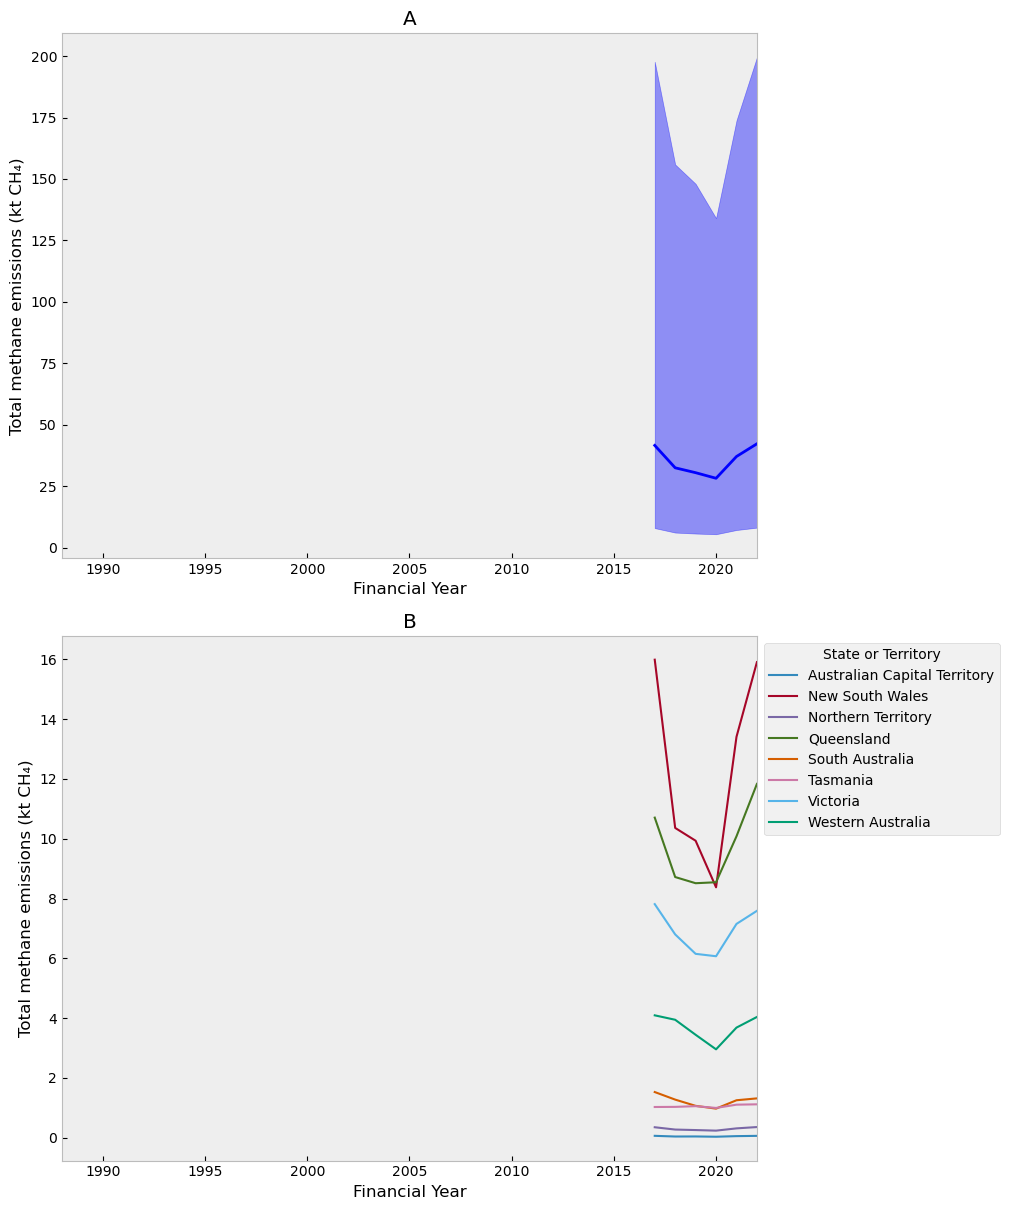

In [106]:
# Create figure with two subplots
fig = plt.figure(figsize=(10.2, 12.2))  # Width, Height in inches
gs = GridSpec(2, 1, figure=fig)

# First plot (Total methane emissions from agricultural ponds)
ax1 = fig.add_subplot(gs[0, 0])
sns.lineplot(
    data=Data10,
    x="FinYear",
    y="TotCH4.ktyear.AdjCoef.ecd",
    legend=False,
    ax=ax1,
    color="b",
)
ax1.fill_between(
    Data10["FinYear"],
    Data10["TotCH4.ktyear_LCI.AdjCoef.ecd"],
    Data10["TotCH4.ktyear_UCI.AdjCoef.ecd"],
    color="blue",
    alpha=0.4,
)
ax1.set_xlabel("Financial Year")
ax1.set_ylabel("Total methane emissions (kt CH₄)")
ax1.set_xlim(1988, 2022)
plt.grid(False)
ax1.set_title("A")

# Second plot (State or territory-wise methane emissions)
ax2 = fig.add_subplot(gs[1, 0])
sns.lineplot(
    data=Data9,
    x="FinYear",
    y="TotCH4.ktyear.AdjCoef.ecd",
    hue="NAME",
    ax=ax2,
    linewidth=1.5,
)
ax2.set_xlabel("Financial Year")
ax2.set_ylabel("Total methane emissions (kt CH₄)")
ax2.set_xlim(1988, 2022)
plt.grid(False)
ax2.set_title("B")
ax2.legend(
    title="State or Territory", loc="upper left", bbox_to_anchor=(1, 1)
)  # Adjust legend position

# Adjust layout
plt.tight_layout()

# Save the combined figure
plt.savefig(plots_dir / "TotEmissions_both.pdf", format="pdf")
plt.savefig(plots_dir / "TotEmissions_both.jpeg", format="jpeg")

# Display the figure
plt.show()

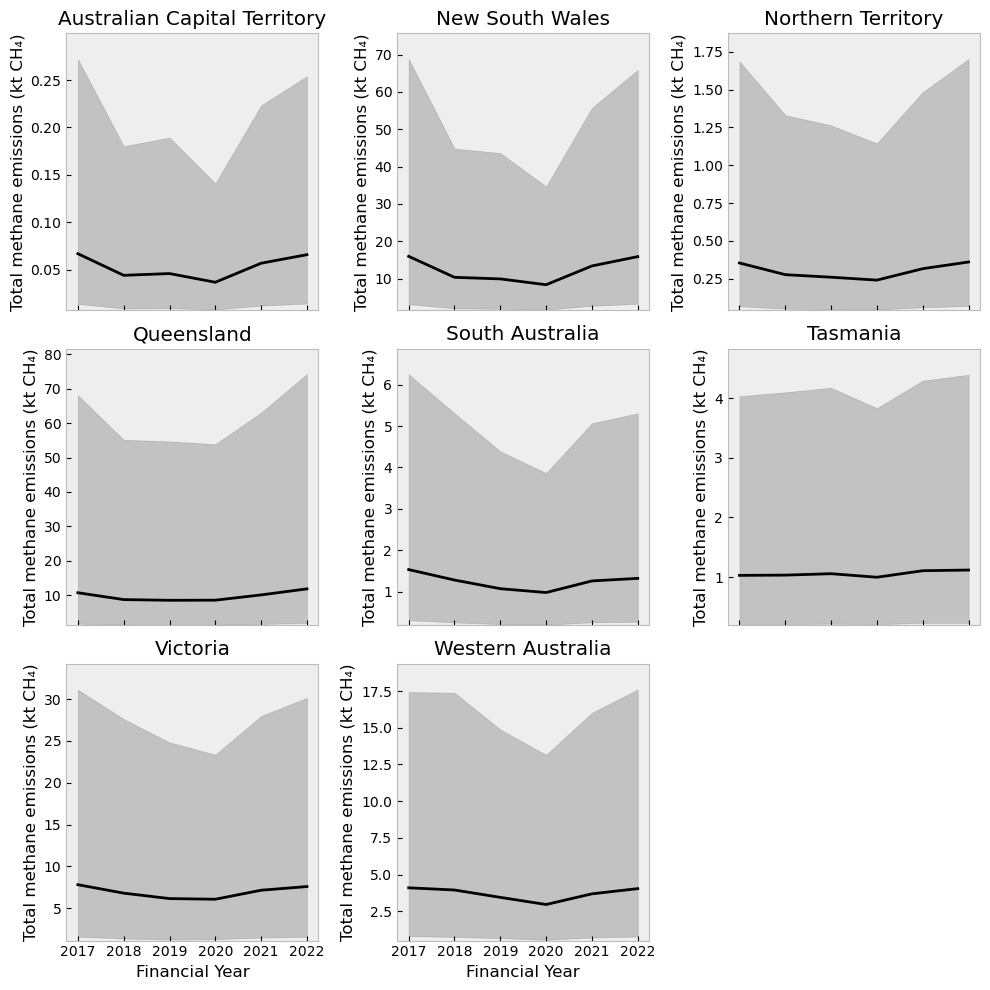

In [107]:
# Divided by States (TotEmissions)
# Determine the unique names and number of plots
unique_names = Data9["NAME"].unique()
n_cols = 3
n_rows = 3  # Or however many you need to fit all unique_names

# Set up the figure for the individual subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10), sharex=True)
axes = axes.flatten()  # Flatten the 2D numpy array to 1D for easy iteration

# Loop through the names and axes to create each subplot
for ax, name in zip(axes, unique_names):
    # Filter the data for this specific name
    subset = Data9[Data9["NAME"] == name]
    # Plot the line and fill for the subset
    sns.lineplot(
        ax=ax, data=subset, x="FinYear", y="TotCH4.ktyear.AdjCoef.ecd", color="black"
    )
    ax.fill_between(
        subset["FinYear"],
        subset["TotCH4.ktyear_LCI.AdjCoef.ecd"],
        subset["TotCH4.ktyear_UCI.AdjCoef.ecd"],
        color="grey",
        alpha=0.4,
    )
    # Set the y-axis limits based on the subset data
    ymin = subset["TotCH4.ktyear_LCI.AdjCoef.ecd"].min() * 0.9
    ymax = subset["TotCH4.ktyear_UCI.AdjCoef.ecd"].max() * 1.1
    ax.set_ylim(ymin, ymax)
    # Set the title for each subplot
    ax.set_title(name)
    ax.set_xlabel("Financial Year")
    ax.set_ylabel("Total methane emissions (kt CH₄)")
    # Remove gridlines for each subplot
    ax.grid(False)

# Hide any unused subplots if you have fewer than 9 names
for i in range(len(unique_names), len(axes)):
    axes[i].set_visible(False)

# Adjust the layout
plt.tight_layout()
# Save the plot
fig.savefig(plots_dir / "TotEmissions_State.pdf")
fig.savefig(plots_dir / "TotEmissions_State.jpeg")
# Show the plot
plt.show()

In [108]:
## =============
## FIGURE 8: Test Tier models
## =============
# Load the Tier data
# TierComp2 data already existing in this work space but you can load it again
# with open(required_data / "TierComp2.pkl", "rb") as file:
#     data = pickle.load(file)
FarmDamData = pd.read_csv(required_data / "FarmDamData.csv")
# Plot the distribution of measured methane emissions from farm dams
# Units of Kg/ha/year

# mg/m2/day = 10^-6 kg/m2/day = 10^-6 * 10^4 kg/ha/day = 10^-6 * 10^4 * 365 kg/ha/year
# kg/ha/year = 3.65 * mg/m2/day

# Units of T/ha/year
# T/ha/year = 3.65 * 10^-3 = 0.00365 mg/m2/day

# Keep only data for Australia
FarmDamData_Aus = FarmDamData[
    FarmDamData["Ref"].isin(
        ["ANU.Fieldwork", "DryFlux", "Grinham", "Ollivier", "Ollivier2"]
    )
].copy()

# Add climate info for Aus
climate_mapping = {
    "ANU.Fieldwork": "Temperate - warm",
    "DryFlux": "Temperate - cool",
    "Grinham": "Subtropical",
    "Ollivier": "Temperate - cool",
    "Ollivier2": "Temperate - cool",
}
FarmDamData_Aus["Climate.Aus"] = FarmDamData_Aus["Ref"].map(climate_mapping)

# Add climate info for Aus
climate_mapping_2 = {
    "Subtropical": "Subtropical",
    "Temperate - cool": "Temperate - cool",
    "Temperate - warm": "Temperate - warm",
    "Tropical - dry": None,
    "Tropical - wet": None,
}
TierComp2["Climate.Aus"] = TierComp2["Climate"].map(climate_mapping_2)

# Add Tier2 to farm dam data
Tier2Climate = TierComp2[["EF_T2.kt", "Climate.Aus"]].drop_duplicates()
Tier2Climate = Tier2Climate[
    Tier2Climate["Climate.Aus"].isin(
        ["Temperate - cool", "Temperate - warm", "Subtropical"]
    )
]

# Merge the data
FarmDamData_Aus = pd.merge(FarmDamData_Aus, Tier2Climate, on="Climate.Aus")

# Add Tier3 to farm dam data
FarmDamData_Aus["EF_T3.kt"] = (
    np.exp(
        0.4287063
        * (
            (1 / (8.617333e-05 * (273.15 + 15)))
            - (1 / (8.617333e-05 * (273.15 + FarmDamData_Aus["Water_Temp_C"])))
        )
        + 5.318143
    )
    * 1000
    / 1000000
)

# Add Tier1 to farm dam data
FarmDamData_Aus["EF_T1.kt"] = 0.228

In [109]:
# Calculate residuals
FarmDamData_Aus["Res_1"] = (
    0.00365 * FarmDamData_Aus["CH4_mgm2day.EbuAdj"] - FarmDamData_Aus["EF_T1.kt"]
)
FarmDamData_Aus["Res_2"] = (
    0.00365 * FarmDamData_Aus["CH4_mgm2day.EbuAdj"] - FarmDamData_Aus["EF_T2.kt"]
)
FarmDamData_Aus["Res_3"] = (
    0.00365 * FarmDamData_Aus["CH4_mgm2day.EbuAdj"] - FarmDamData_Aus["EF_T3.kt"]
)

# Calculate mean of squared residuals
mean_res_1_squared = (FarmDamData_Aus["Res_1"] ** 2).mean()
mean_res_2_squared = (FarmDamData_Aus["Res_2"] ** 2).mean()
mean_res_3_squared = (FarmDamData_Aus["Res_3"] ** 2).mean()

print(f"Mean of squared Res_1: {mean_res_1_squared}")
print(f"Mean of squared Res_2: {mean_res_2_squared}")
print(f"Mean of squared Res_3: {mean_res_3_squared}")

Mean of squared Res_1: 5.141937519607176
Mean of squared Res_2: 5.199523397605603
Mean of squared Res_3: 4.966593610232895


In [110]:
FarmDamData_Aus

,Ref,Latitude,Longitude,CH4_mgm2day.mean,Water_Temp_C,Temp.annual,CH4_mgm2day.EbuAdj,CH4_mgm2day.EbuAdj.LCI,CH4_mgm2day.EbuAdj.UCI,Water_Temp_K,Boltzmann_15C,CH4_mgm2day.EbuAdj.15C,Loc,Climate.Aus,EF_T2.kt,EF_T3.kt,EF_T1.kt,Res_1,Res_2,Res_3
0,ANU.Fieldwork,-33.515984,148.563043,13.988258,18.533333,18.397369,54.453166,70.854167,42.782465,291.683333,0.487845,44.176764,Temperate (Australia; N = 165),Temperate - warm,0.2376,0.251460,0.228,-0.029246,-0.038846,-0.052706
1,ANU.Fieldwork,-33.507176,148.592199,1.814559,14.733333,18.266697,6.999248,9.083099,5.512825,287.883333,-0.037304,7.112084,Temperate (Australia; N = 165),Temperate - warm,0.2376,0.200768,0.228,-0.202453,-0.212053,-0.175221
2,ANU.Fieldwork,-33.524183,148.565278,0.605022,19.433333,18.482098,2.369286,3.088341,1.858436,292.583333,0.610224,1.823909,Temperate (Australia; N = 165),Temperate - warm,0.2376,0.265005,0.228,-0.219352,-0.228952,-0.256357
3,ANU.Fieldwork,-34.839408,149.448307,3.814813,14.200000,13.654881,10.864011,13.375177,9.012439,287.350000,-0.112121,11.398965,Temperate (Australia; N = 165),Temperate - warm,0.2376,0.194431,0.228,-0.188346,-0.197946,-0.154777
4,ANU.Fieldwork,-34.853581,149.429012,22.579635,15.300000,13.654238,64.300852,79.163562,53.342080,288.450000,0.041885,63.156545,Temperate (Australia; N = 165),Temperate - warm,0.2376,0.207701,0.228,0.006698,-0.002902,0.026997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,Ollivier2,-37.747517,143.970484,30.898639,8.275000,13.521925,87.281721,107.422388,72.441976,281.425000,-0.962361,131.856126,Temperate (Australia; N = 165),Temperate - cool,0.1518,0.135040,0.228,0.090578,0.166778,0.183538
173,Ollivier2,-37.742922,143.974816,8.453303,8.075000,13.537000,23.900676,29.416839,19.835989,281.225000,-0.991686,36.563444,Temperate (Australia; N = 165),Temperate - cool,0.1518,0.133353,0.228,-0.140763,-0.064563,-0.046116
174,Ollivier2,-37.740489,143.960022,0.334906,7.050000,13.687283,0.955659,1.176657,0.792683,280.200000,-1.142635,1.559711,Temperate (Australia; N = 165),Temperate - cool,0.1518,0.124997,0.228,-0.224512,-0.148312,-0.121509
175,Ollivier2,-37.738764,143.962383,2.060862,7.650000,13.687283,5.880703,7.240627,4.877821,280.800000,-1.054141,9.240474,Temperate (Australia; N = 165),Temperate - cool,0.1518,0.129830,0.228,-0.206535,-0.130335,-0.108365


In [111]:
# Best Fitting model
FarmDamData_Aus_lm = smf.ols(
    formula='np.log10(FarmDamData_Aus["CH4_mgm2day.EbuAdj"]) ~ Water_Temp_C',
    data=FarmDamData_Aus,
).fit()

# Print the summary
print(FarmDamData_Aus_lm.summary())

# Print the ANOVA table
print(sm.stats.anova_lm(FarmDamData_Aus_lm, typ=2))

                                           OLS Regression Results                                          
Dep. Variable:     np.log10(FarmDamData_Aus["CH4_mgm2day.EbuAdj"])   R-squared:                       0.142
Model:                                                         OLS   Adj. R-squared:                  0.137
Method:                                              Least Squares   F-statistic:                     28.91
Date:                                             Mon, 09 Dec 2024   Prob (F-statistic):           2.40e-07
Time:                                                     12:12:42   Log-Likelihood:                -224.28
No. Observations:                                              177   AIC:                             452.6
Df Residuals:                                                  175   BIC:                             458.9
Df Model:                                                        1                                         
Covariance Type:            

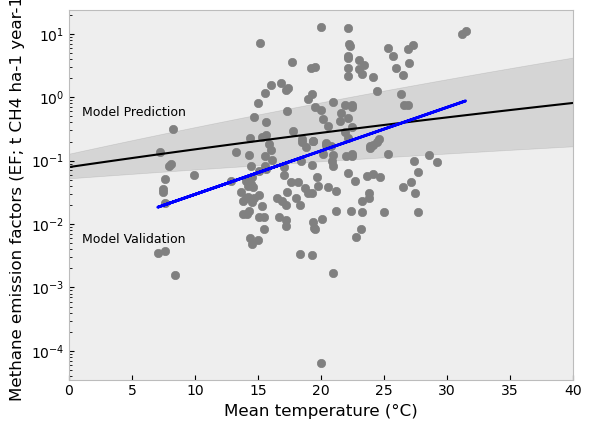

In [112]:
# Plot the data (simpler version)
# Define a color mapping
color_mapping = {
    "Temperate - cool": "grey",
    "Temperate - warm": "grey",
    "Subtropical": "grey",
}
# Create a new figure
plt.figure(figsize=(6.5, 4.8))

# Plot Tier 3 ribbon
plt.fill_between(
    TierComp2["Temp"],
    TierComp2["EF_T3_LCI"],
    TierComp2["EF_T3_UCI"],
    alpha=0.1,
    color="black",
)

# Plot Tier 3 line
plt.plot(TierComp2["Temp"], TierComp2["EF_T3"], linewidth=1.5, color="black")

# Plot farm dam data
for climate in FarmDamData_Aus["Climate.Aus"].unique():
    plt.scatter(
        FarmDamData_Aus[FarmDamData_Aus["Climate.Aus"] == climate]["Water_Temp_C"],
        0.00365
        * FarmDamData_Aus[FarmDamData_Aus["Climate.Aus"] == climate][
            "CH4_mgm2day.EbuAdj"
        ],
        label=climate,
        color=color_mapping[climate],
    )

# Fit a straight line to the log-transformed data
slope, intercept, r_value, p_value, std_err = stats.linregress(
    FarmDamData_Aus["Water_Temp_C"],
    np.log10(0.00365 * FarmDamData_Aus["CH4_mgm2day.EbuAdj"]),
)
# Calculate the line of fit
line_of_fit = 10 ** (intercept + slope * FarmDamData_Aus["Water_Temp_C"])
# Plot the line of fit
plt.plot(FarmDamData_Aus["Water_Temp_C"], line_of_fit, "b")
# Set the scale of the y-axis
plt.yscale("log")
# Set the limits of the x-axis
plt.xlim(0, 40)
# Add label above the black line for Model Prediction
plt.text(1, 10 ** (-0.3), "Model Prediction", fontsize=9, color="black", ha="left")
plt.text(1, 10 ** (-2.3), "Model Validation", fontsize=9, color="black", ha="left")
# Add labels
plt.xlabel("Mean temperature (°C)")
plt.ylabel("Methane emission factors (EF; t CH4 ha-1 year-1)")
plt.grid(False)
# Add a legend
# plt.legend()
# Save the plot as a PDF file
plt.savefig(plots_dir / "EFtemp.pdf", format="pdf")
# Show the plot
plt.show()

In [113]:
# Define the Boltzmann constant
Boltzmann_const_evK = 8.617333262145 * 1e-5

# Calculate Boltzmann_15C
FarmDamData_Aus["Boltzmann_15C"] = (1 / (Boltzmann_const_evK * (273.15 + 15))) - (
    1 / (Boltzmann_const_evK * (273.15 + FarmDamData_Aus["Water_Temp_C"]))
)

# Fit the model
Boltzmann_lm = smf.ols(
    formula='np.log(FarmDamData_Aus["CH4_mgm2day.EbuAdj"]) ~ Boltzmann_15C',
    data=FarmDamData_Aus,
).fit()

# Print the summary
print(Boltzmann_lm.summary())
# Print the confidence intervals
print(Boltzmann_lm.conf_int())

                                          OLS Regression Results                                         
Dep. Variable:     np.log(FarmDamData_Aus["CH4_mgm2day.EbuAdj"])   R-squared:                       0.141
Model:                                                       OLS   Adj. R-squared:                  0.136
Method:                                            Least Squares   F-statistic:                     28.67
Date:                                           Mon, 09 Dec 2024   Prob (F-statistic):           2.66e-07
Time:                                                   12:12:42   Log-Likelihood:                -372.01
No. Observations:                                            177   AIC:                             748.0
Df Residuals:                                                175   BIC:                             754.4
Df Model:                                                      1                                         
Covariance Type:                              

In [114]:
# Only for Ollivier
FarmDamData_Oll = FarmDamData_Aus[
    FarmDamData_Aus["Ref"].isin(["Ollivier", "Ollivier2"])
]
# Ensure no SettingWithCopyWarning to keep original dataframe in memory
FarmDamData_Oll = FarmDamData_Oll.copy()

# Calculate residuals
FarmDamData_Oll["Res_3"] = np.log10(
    0.00365 * FarmDamData_Oll["CH4_mgm2day.EbuAdj"]
) - np.log10(
    np.exp(
        0.4287063
        * (
            (1 / (8.617333e-05 * (273.15 + 15)))
            - (1 / (8.617333e-05 * (273.15 + FarmDamData_Oll["Water_Temp_C"])))
        )
        + 5.318143
    )
    * 1000
    / 1000000
)
FarmDamData_Oll["Res_2"] = np.log10(
    0.00365 * FarmDamData_Oll["CH4_mgm2day.EbuAdj"]
) - np.log10(
    0.1518
)  # Temperate - cool
FarmDamData_Oll["Res_1"] = np.log10(
    0.00365 * FarmDamData_Oll["CH4_mgm2day.EbuAdj"]
) - np.log10(0.228)
FarmDamData_Oll["Res_0"] = np.log10(
    0.00365 * FarmDamData_Oll["CH4_mgm2day.EbuAdj"]
) - np.mean(np.log10(0.00365 * FarmDamData_Oll["CH4_mgm2day.EbuAdj"]))

# Calculate predictions
FarmDamData_Oll["Pred_3"] = np.log10(
    np.exp(
        0.4287063
        * (
            (1 / (8.617333e-05 * (273.15 + 15)))
            - (1 / (8.617333e-05 * (273.15 + FarmDamData_Oll["Water_Temp_C"])))
        )
        + 5.318143
    )
    * 1000
    / 1000000
)
FarmDamData_Oll["Pred_2"] = np.log10(0.1518)  # Temperate - cool
FarmDamData_Oll["Pred_1"] = np.log10(0.228)
FarmDamData_Oll["Pred_0"] = np.mean(
    np.log10(0.00365 * FarmDamData_Oll["CH4_mgm2day.EbuAdj"])
)

# Use a LM for comparison
lm_model = smf.ols(
    formula='np.log10(FarmDamData_Oll["CH4_mgm2day.EbuAdj"]) ~ Water_Temp_C',
    data=FarmDamData_Oll,
).fit()
FarmDamData_Oll["Res_Best"] = lm_model.resid
FarmDamData_Oll["Pred_Best"] = lm_model.predict(FarmDamData_Oll[["Water_Temp_C"]])

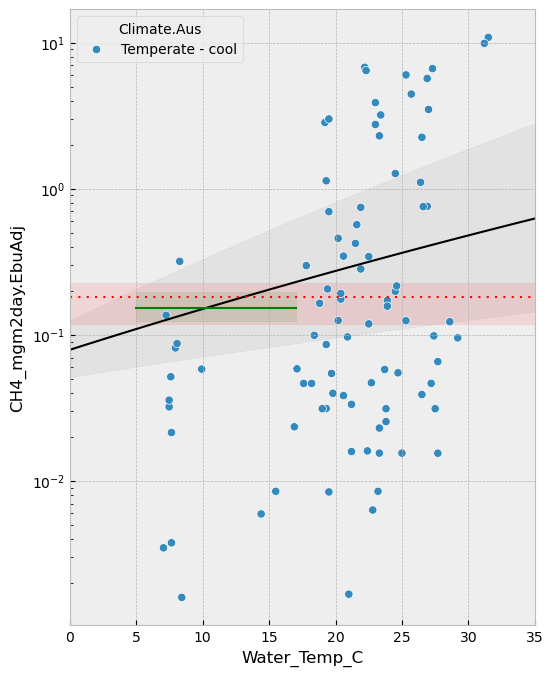

In [115]:
# plot the Data
# Filter data
TierComp2 = TierComp2[TierComp2["Temp"] < 41]
FarmDamData_Oll = FarmDamData_Aus[
    FarmDamData_Aus["Ref"].isin(["Ollivier", "Ollivier2"])
]

# Create a new figure
plt.figure(figsize=(6, 8))

# Tier 3 ribbon and line
plt.fill_between(
    TierComp2["Temp"],
    TierComp2["EF_T3_LCI"],
    TierComp2["EF_T3_UCI"],
    color="grey",
    alpha=0.1,
)
plt.plot(TierComp2["Temp"], TierComp2["EF_T3"], "k-", linewidth=1.5)
# Tier 1 ribbon and line
plt.fill_between(
    TierComp2["Temp"],
    TierComp2["EF_T1_LCI"],
    TierComp2["EF_T1_UCI"],
    color="r",
    alpha=0.1,
)
(line,) = plt.plot(TierComp2["Temp"], TierComp2["EF_T1"], "r", linewidth=1.5)
line.set_dashes([1, 3])
# Tier 2 ribbon and line
TierComp2_temp_cool = TierComp2[TierComp2["Climate.Aus"] == "Temperate - cool"]
plt.fill_between(
    TierComp2_temp_cool["Temp"],
    TierComp2_temp_cool["EF_T2.kt_LCI"],
    TierComp2_temp_cool["EF_T2.kt_UCI"],
    color="g",
    alpha=0.1,
)
plt.plot(
    TierComp2_temp_cool["Temp"], TierComp2_temp_cool["EF_T2.kt"], "g-", linewidth=1.5
)

# Farm dam data
sns.scatterplot(
    data=FarmDamData_Oll,
    x="Water_Temp_C",
    y=0.00365 * FarmDamData_Oll["CH4_mgm2day.EbuAdj"],
    hue="Climate.Aus",
)

# Set y scale to log and limit x axis
plt.yscale("log")
plt.xlim(0, 35)
# Show the plot
plt.show()

In [116]:
## =============
## Test water fluctuations
## =============
# Here we show how much we would overestimate total water if we were to assume always full dams
# load validation data by Nick
ValData = pd.read_csv(required_data / "validation_output_WeatherTOWater.csv")

# filter data
ValData = ValData[
    (ValData["manual_water_area"] > 100)
    & (ValData["dam_area"] > 100)
    & (ValData["dam_area"] < 100000)
]
# create new columns
ValData["overestimation_m2"] = ValData["dam_area"] - ValData["manual_water_area"]
ValData["overestimation_perc"] = ValData["overestimation_m2"] / ValData["dam_area"]

ValData["PercFull"] = ValData["manual_water_area"] / ValData["dam_area"]

# MAE WtW
MAE_WtW = mae(ValData["manual_water_area"], ValData["pred_water_area"])  # m2
# MAPE WtW
MAPE_WtW = MAE_WtW / ValData["manual_water_area"].mean()  # m2
# MAE of assuming max size
MAE_max = mae(ValData["manual_water_area"], ValData["dam_area"])  # m2
# MAPE of assuming max size
MAPE_max = MAE_max / ValData["manual_water_area"].mean()  # m2
MAPE_max

0.7743348966865261